<a href="https://colab.research.google.com/github/saugatabose28/LLM-Detector-Experiments-HC3-Dataset/blob/main/Ai_vs_Human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mtesconi/twitter-deep-fake-text")

print("Path to dataset files:", path)

100%|██████████| 345k/345k [00:00<00:00, 966kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mtesconi/twitter-deep-fake-text/versions/8


In [ ]:
%pip install transformers
# Import necessary libraries
!pip install -U transformers tensorflow pandas scipy datasets

# Import necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from collections import defaultdict
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import GPT2LMHeadModel, GPT2Tokenizer
# Import PyTorch BertModel and AutoModel for potential flexibility
from transformers import BertModel, AutoModel
from transformers import TFBertModel, BertTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification, DebertaV2Tokenizer, DebertaV2ForSequenceClassification

import scipy.sparse # Import scipy.sparse
import io # Import io for StringIO

import torch
from datasets import Dataset

# For the autoencoder and other deep learning models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Check for GPU availability
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available:", gpu_available)
    # Ensure TensorFlow uses the GPU
    tf.config.experimental.set_visible_devices(gpu_available[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_available[0], True)
else:
    print("No GPU available, using CPU.")

# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

# Define data paths
data_path="drive/My Drive/Colab Notebooks"
reddit_path = data_path + '/reddit_filtered_dataset.csv'
tweet_path = data_path + '/Tweep Dataset.csv'
mixedAiGeneratedData_path = data_path + '/AI Dataset.csv'


In [ ]:
# --- Consolidated Functions for Data Loading, Cleaning, Tokenization, and Models ---

# Removed: os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Enable CUDA launch blocking for debugging
# Removed: PyTorch imports

def fit_vectorizer_on_human(human_texts):
    """
    Fit TF-IDF ONLY on the human training texts of the source domain
    (prevents leakage of AI tokens/features).
    """
    vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), lowercase=True)
    X_human = vec.fit_transform(human_texts)
    return vec, X_human

def to_matrix(vec, texts):
    """Transforms text data into TF-IDF matrix using a fitted vectorizer."""
    return vec.transform(texts)

def occ_same_domain_split(df, human_train_frac=0.8, seed=RANDOM_STATE):
    """
    Same-domain OCC split:
      - Train on HUMAN only (human_train_frac)
      - Test on remaining HUMAN + ALL AI (from the same dataframe)
    Returns: train_human_texts, test_texts, test_labels
    """
    df = df[['cleaned', 'label']].dropna().copy()
    human_df = df[df['label'] == 0]
    ai_df    = df[df['label'] == 1]

    # Ensure there are enough samples for stratification
    if len(human_df) < 2 or (1.0 - human_train_frac) * len(human_df) < 1:
         print(f"Warning: Not enough human samples for stratified split in same-domain for a {human_train_frac} training fraction.")
         # Handle cases with insufficient data for splitting
         if len(human_df) > 0:
             train_human = human_df['cleaned']
             eval_human = pd.DataFrame(columns=['cleaned', 'label']) # Empty eval set
         else:
             train_human = pd.Series(dtype=str)
             eval_human = pd.DataFrame(columns=['cleaned', 'label']) # Empty eval set
    else:
        train_human, eval_human = train_test_split(
            human_df, test_size=(1.0 - human_train_frac), random_state=seed, stratify=human_df['label']
        )

    test_df = pd.concat([eval_human, ai_df], ignore_index=True)
    test_df = test_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    return train_human['cleaned'], test_df['cleaned'], test_df['label'].astype(int).values

def occ_cross_domain_split(source_df, target_df):
    """
    Cross-domain OCC:
      - Train on ALL HUMAN from source_df
      - Test on ALL (HUMAN + AI) from target_df
    Returns: train_human_texts, test_texts, test_labels
    """
    s = source_df[['cleaned', 'label']].dropna().copy()
    t = target_df[['cleaned', 'label']].dropna().copy()

    train_human = s[s['label'] == 0]['cleaned']
    test_texts  = t['cleaned']
    test_labels = t['label'].astype(int).values
    return train_human, test_texts, test_labels

def evaluate_model_performance(y_true, y_pred, model_name, dataset_tag):
    """
    Evaluates model predictions and prints a report and confusion matrix.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        model_name: Name or tag of the model.
        dataset_tag: String tag for the dataset/regime being evaluated.

    Returns:
        A dictionary containing evaluation metrics (Accuracy, Micro-F1, Macro-F1).
    """
    # Ensure labels are numpy arrays and 1-dimensional
    y_true = np.array(y_true).astype(int).flatten()
    y_pred = np.array(y_pred).astype(int).flatten()

    print(f"--- Debug Info for {model_name} - {dataset_tag} ---")
    print(f"Shape of y_true: {y_true.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")
    print("--- End Debug Info ---")


    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    f1_ma = f1_score(y_true, y_pred, average='macro')

    # Print evaluation header and metrics
    print(f"\n\033[1m{model_name} - {dataset_tag}\033[0m")
    print(f"Accuracy : {acc:.4f}")
    print(f"Micro-F1: {micro_f1:.4f}")
    print(f"Macro-F1: {f1_ma:.4f}")
    print("\nClassification Report:")

    # Handle cases where target_names might be missing due to no samples in a class
    target_names = ['Human(0)','AI(1)']
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    filtered_target_names = [name for i, name in enumerate(target_names) if i in unique_labels]

    print(classification_report(y_true, y_pred, target_names=filtered_target_names, zero_division=0))

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5)) # Adjust figure size if needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=filtered_target_names, yticklabels=filtered_target_names)
    plt.title(f"Confusion Matrix — {model_name} - {dataset_tag}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {
        "Model": model_name,
        "Regime": dataset_tag,
        "Accuracy": acc,
        "Micro-F1": micro_f1,
        "Macro-F1": f1_ma
    }


def eval_print(y_true, y_pred, title):
    """Evaluates model predictions and prints a report and confusion matrix using the consolidated function."""
    # Call the consolidated evaluation function
    # We use 'title' as model_name and a placeholder for dataset_tag
    metrics = evaluate_model_performance(y_true, y_pred, model_name=title, dataset_tag="OCC Evaluation")

    return metrics

def build_autoencoder(input_dim, hidden=256, bottleneck=128, lr=1e-3):
    """Builds a simple dense autoencoder model."""
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        inp = keras.Input(shape=(input_dim,))
        x   = layers.Dense(hidden, activation='relu')(inp)
        x   = layers.Dense(bottleneck, activation='relu')(x)
        x   = layers.Dense(hidden, activation='relu')(x)
        out = layers.Dense(input_dim, activation='linear')(x)
        model = keras.Model(inp, out)
        model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')
    return model

def autoencoder_predict_labels(X_train_sparse, X_test_sparse, svd_dim=512, epochs=15, batch=256, q=0.95):
    """
    Train AE on human-only TF-IDF (sparse) via SVD→dense, MinMax scale.
    Predict AI if reconstruction error > q-quantile of train errors.
    Returns: y_pred (0/1), recon_errors_test
    """
    svd = TruncatedSVD(n_components=svd_dim, random_state=RANDOM_STATE)
    Xtr = svd.fit_transform(X_train_sparse)
    Xte = svd.transform(X_test_sparse)

    scaler = MinMaxScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    # Use GPU if available for training
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        ae = build_autoencoder(input_dim=svd_dim, hidden=256, bottleneck=128, lr=1e-3)
        ae.fit(Xtr_s, Xtr_s, epochs=epochs, batch_size=batch, verbose=0, validation_split=0.1, shuffle=True)

        tr_rec = np.mean((Xtr_s - ae.predict(Xtr_s, verbose=0))**2, axis=1)
        # Corrected typo: Changed 'te_s' to 'Xte_s'
        te_rec = np.mean((Xte_s - ae.predict(Xte_s, verbose=0))**2, axis=1)


    tau = np.quantile(tr_rec, q)
    y_pred = (te_rec > tau).astype(int)  # anomaly => AI(1)
    return y_pred, te_rec

def fit_predict_occ(model, X_train, X_test):
    """
    Fit model on human-train (X_train) and predict on X_test.
    Map sklearn output {+1,-1} to {human=0, AI=1}.
    """
    # Check if the model is IsolationForest, which can handle sparse data
    if isinstance(model, IsolationForest):
        # If input is sparse, keep it sparse for IsolationForest
        if isinstance(X_train, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
             X_train_processed = X_train
             X_test_processed = X_test
        else:
             # If input is already dense (like numpy array), convert to CSR for IsolationForest
             X_train_processed = scipy.sparse.csr_matrix(X_train)
             X_test_processed = scipy.sparse.csr_matrix(X_test)
    else:
        # For other models (like EllipticEnvelope), convert sparse data to dense
        if isinstance(X_train, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            X_train_processed = X_train.toarray()
        else:
            X_train_processed = X_train # Already dense

        if isinstance(X_test, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            X_test_processed = X_test.toarray()
        else:
            X_test_processed = X_test # Already dense


    # Fit the model. For EllipticEnvelope, a warning "The covariance matrix
    # associated to your dataset is not full rank" might occur if the number
    # of features is greater than the number of samples or due to high
    # multicollinearity, which is common with TF-IDF data.
    model.fit(X_train_processed)
    y_raw = model.predict(X_test_processed)  # +1 inlier, -1 outlier
    y_pred = np.where(y_raw == 1, 0, 1)
    return y_pred

def build_cnn_model(input_dim, embedding_dim=100, filters=128, kernel_size=5, pool_size=4, vocab_size=5000, maxlen=500):
    """
    Builds a simple Convolutional Neural Network (CNN) model for text classification.

    Args:
        input_dim: The input dimension (number of features, e.g., from TF-IDF).
        embedding_dim: Dimension of the embedding layer (if used, though not directly with sparse TF-IDF).
                       This parameter is kept for potential future use with embedding layers.
        filters: Number of convolutional filters.
        kernel_size: Size of the convolutional kernel.
        pool_size: Size of the pooling window.
        vocab_size: Vocabulary size (relevant if using embedding layer).
        maxlen: Maximum sequence length (relevant if using embedding layer).

    Returns:
        A compiled Keras Sequential model.
    """
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # For TF-IDF input, we directly use the input dimension
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(input_dim,), dtype=tf.float32), # Specify dtype
            tf.keras.layers.Reshape((input_dim, 1)), # Reshape for Conv1D
            tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=pool_size),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid') # Binary classification
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm_model(input_dim, lstm_units=128, vocab_size=5000, maxlen=500):
    """
    Builds a Bidirectional LSTM (BiLSTM) model for text classification.

    Args:
        input_dim: The input dimension (number of features, e.g., from TF-IDF).
        lstm_units: Number of units in the LSTM layers.
        vocab_size: Vocabulary size (relevant if using embedding layer).
        maxlen: Maximum sequence length (relevant if using embedding layer).

    Returns:
        A compiled Keras Sequential model.
    """
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # For TF-IDF input, we need to reshape for LSTM layers
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(input_dim,), dtype=tf.float32), # Specify dtype
            tf.keras.layers.Reshape((input_dim, 1)), # Reshape for LSTM
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid') # Binary classification
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_bilstm_model(input_dim, embedding_dim=100, conv_filters=128, kernel_size=5, pool_size=4, lstm_units=128):
    """
    Builds a model combining CNN and Bidirectional LSTM for text classification.
    Assumes input is TF-IDF features, reshaped for Conv1D.
    Uses tf.keras.layers explicitly.
    """
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(input_dim,), dtype=tf.float32), # Specify dtype
            tf.keras.layers.Reshape((input_dim, 1)), # Reshape for Conv1D
            tf.keras.layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=pool_size),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid') # Binary classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Removed PyTorch BERT+BiLSTM model and related functions


def train_and_evaluate_dl_model(model, X_train, y_train, X_test, y_test, dataset_tag, model_name, epochs=10, batch_size=32):
    """
    Trains a deep learning model and evaluates its performance.

    Args:
        model: A compiled Keras model.
        X_train: Training features (e.g., TF-IDF matrix or tokenized data).
        y_train: Training labels.
        X_test: Testing features (e.g., TF-IDF matrix or tokenized data).
        y_test: Testing labels.
        dataset_tag: String tag for the dataset/regime being evaluated.
        model_name: Name of the deep learning model (e.g., 'Simple CNN', 'BiLSTM', 'CNN+BiLSTM', 'BERT+BiLSTM').
        epochs: Number of training epochs.
        batch_size: Batch size for training.

    Returns:
        A dictionary containing evaluation metrics (Accuracy, Micro-F1, Macro-F1).
    """
    # Convert sparse matrices to dense if necessary for Keras
    if isinstance(X_train, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
        X_train = X_train.toarray()
    if isinstance(X_test, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
        X_test = X_test.toarray()

    # Ensure labels are numpy arrays and correct type
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    # Convert data to TensorFlow tensors and move to GPU if available
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        # Ensure inputs are TensorFlow tensors with correct dtype
        train_input = tf.convert_to_tensor(X_train, dtype=tf.float32)
        test_input = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32) # Use float32 for labels if using binary_crossentropy
        y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


        # Train the model
        model.fit(train_input, y_train_tensor, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)

        # Make predictions
        y_pred_proba = model.predict(test_input, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int) # Threshold at 0.5 for binary classification


    # Evaluate the model using the existing function
    metrics = evaluate_model_performance(y_test, y_pred, model_name=model_name, dataset_tag=dataset_tag)

    return metrics


# Added back RoBERta training function
def train_and_evaluate_roberta(train_data, test_data, dataset_tag):
    """
    Fine-tunes and evaluates a RoBERta model for text classification using tokenized data.

    Args:
        train_data: A Dataset object containing 'input_ids', 'attention_mask', and 'label'.
        test_data: A Dataset object containing 'input_ids', 'attention_mask', and 'label'.
        dataset_tag: String tag for the dataset/regime being evaluated.

    Returns:
        A dictionary containing evaluation metrics (Accuracy, Micro-F1, Macro-F1).
    """
    # Load pre-trained RoBERta model
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=3,              # number of training epochs
        per_device_train_batch_size=16,  # batch size for training
        per_device_eval_batch_size=64,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=10,
        eval_strategy="epoch",     # evaluate every epoch - Corrected parameter name
        save_strategy="epoch",           # save every epoch
        load_best_model_at_end=True,     # load the best model when training ends
        metric_for_best_model="eval_loss", # metric to use to compare models
        greater_is_better=False # A lower loss is better
    )

    # Instantiate Trainer
    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_data,            # training dataset (already tokenized and formatted)
        eval_dataset=test_data               # evaluation dataset (already tokenized and formatted)
    )

    # Fine-tune the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()

    # Extract predictions
    predictions = trainer.predict(test_data)
    # Access predictions from the tuple
    y_pred = predictions.predictions.argmax(-1)
    # Get true labels from the test dataset
    y_true = test_data['label']


    # Use the existing evaluation function
    metrics = evaluate_model_performance(y_true, y_pred, model_name="RoBERta Fine-tune", dataset_tag=dataset_tag)

    return metrics

# Removed DistilBERT and DeBERTa training functions


def evaluate_gpt2_perplexity(train_texts, test_texts, test_labels, dataset_tag, q=0.95):
    """
    Evaluates GPT2 perplexity as a zero-shot baseline for AI text detection.

    Args:
        train_texts: List or Series of training texts (human).
        test_texts: List or Series of testing texts.
        test_labels: List or Series of testing labels.
        dataset_tag: String tag for the dataset/regime being evaluated.
        q: Quantile for setting the perplexity threshold.

    Returns:
        A dictionary containing evaluation metrics (Accuracy, Micro-F1, Macro-F1).
    """
    # Load pre-trained GPT2 language model and tokenizer
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    # Add padding token
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

    # Function to calculate perplexity
    def calculate_perplexity(texts):
        perplexities = []
        for text in texts:
            # Ensure text is a string and handle potential NaN values
            if not isinstance(text, str) or not text.strip(): # Added check for empty string after strip
                perplexities.append(np.nan)
                continue

            # Tokenize and prepare input
            # Add return_tensors='pt' to get PyTorch tensors
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

            # Check if input_ids is empty after tokenization
            if inputs["input_ids"].shape[1] == 0:
                perplexities.append(np.nan)
                continue


            # Move tensors to the same device as the model
            if torch.cuda.is_available():
                inputs = {key: val.to(model.device) for key, val in inputs.items()}


            # Calculate loss
            with torch.no_grad():
                outputs = model(**inputs, labels=inputs["input_ids"])
                loss = outputs.loss

            # Calculate perplexity
            if loss is not None:
                 perplexity = torch.exp(loss).item()
                 perplexities.append(perplexity)
            else:
                 # Handle cases where loss is None (e.g., empty input after tokenization)
                 perplexities.append(np.nan) # Or some other indicator


        return np.array(perplexities)

    # Calculate perplexity for training (human) texts
    train_perplexities = calculate_perplexity(train_texts)

    # Remove NaN values before calculating the threshold
    train_perplexities_cleaned = train_perplexities[~np.isnan(train_perplexities)]

    # Calculate perplexity threshold based on training perplexities
    # Ensure there are enough non-NaN values to calculate quantile
    if len(train_perplexities_cleaned) > 0:
        perplexity_threshold = np.quantile(train_perplexities_cleaned, q)
    else:
        # Handle case with no valid training perplexities
        print("Warning: No valid training perplexities to calculate threshold. Using a default high threshold.")
        perplexity_threshold = np.finfo(np.float32).max # Use a very high threshold


    # Calculate perplexity for testing texts
    test_perplexities = calculate_perplexity(test_texts)

    # Classify testing texts based on the threshold
    # Treat NaN perplexities in test set as potentially anomalous (AI)
    y_pred = np.where(np.isnan(test_perplexities) | (test_perplexities > perplexity_threshold), 1, 0)


    # Use the existing evaluation function
    metrics = evaluate_model_performance(test_labels, y_pred, model_name="GPT2 Perplexity", dataset_tag=dataset_tag)

    return metrics

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, dataset_tag):
    """
    Trains a model and evaluates its performance.

    Args:
        model: The model to train and evaluate.
        X_train: Training features.
        y_train: Training labels.
        X_test: Testing features.
        y_test: Testing labels.
        dataset_tag: String tag for the dataset/regime being evaluated.

    Returns:
        A dictionary containing evaluation metrics (Accuracy, Micro-F1, Macro-F1).
    """
    # Ensure labels are integers
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    # Fit the model. For sklearn models, X_train and X_test should be dense arrays for some estimators.
    # Convert sparse to dense if needed for the specific model, although most sklearn models handle sparse.
    # Let's rely on the caller to provide appropriate X_train/X_test format for sklearn models.
    # The run_experiment_regime function already handles vectorization.

    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Call the consolidated evaluation function
    metrics = evaluate_model_performance(y_test, y_pred, model_name=type(model).__name__, dataset_tag=dataset_tag)

    return metrics


def vectorize_data(text_series, vectorizer=None):
    """
    Vectorizes text data using TF-IDF.

    Args:
        text_series: Pandas Series containing text data.
        vectorizer: Optional, a pre-fitted TfidfVectorizer object.

    Returns:
        A tuple containing the TF-IDF matrix and the fitted/provided TfidfVectorizer.
    """
    if vectorizer is None:
        vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), lowercase=True)
        tfidf_matrix = vec.fit_transform(text_series)
    else:
        vec = vectorizer
        tfidf_matrix = vec.transform(text_series)

    return tfidf_matrix, vec


def run_experiment_regime(source_df, target_df, tag, same_domain=True):
    """
    Runs the experiment for a specific regime (same-domain or cross-domain)
    and evaluates baseline and one-class models, including RoBERta, GPT2, CNN, BiLSTM, and BERT+BiLSTM.
    Handles data preparation for different model types.

    Args:
        source_df: The dataframe used as the source for training data (should include tokenized data).
        target_df: The dataframe used as the target for testing data (should include tokenized data).
        tag: A string tag representing the regime (e.g., 'Reddit→Tweet').
        same_domain: Boolean, True if source and target are the same dataset.

    Returns:
        A list of dictionaries containing the results for all models in the regime.
    """
    results = []

    # No sampling within this function based on user's clarification.
    # Sampling will be done on the input dataframes before calling this function.


    if same_domain:
        # Same-domain split for OCC models and GPT2 (train on human only)
        train_human_texts, test_texts_occ, y_test_occ = occ_same_domain_split(source_df, human_train_frac=0.8)
        vec_occ, X_train_occ = fit_vectorizer_on_human(train_human_texts)
        X_test_occ = to_matrix(vec_occ, test_texts_occ)

        # For same-domain baseline models
        X_source_full = source_df[['cleaned', 'label', 'input_ids', 'attention_mask']].dropna().copy()
        y_source_full = X_source_full['label'].astype(int)

        # Removed stratify to unblock execution, as it was causing persistent errors
        X_train_baseline_data, X_test_baseline_data, y_train_baseline, y_test_baseline = train_test_split(
            X_source_full, y_source_full, test_size=0.2, random_state=RANDOM_STATE
        )

        # Vectorize for sklearn baseline models using the 'cleaned' text column
        X_train_baseline_tfidf, vec_baseline = vectorize_data(X_train_baseline_data['cleaned'])
        X_test_baseline_tfidf = to_matrix(vec_baseline, X_test_baseline_data['cleaned'])

        # Prepare tokenized data for RoBERta
        # Ensure data exists before trying to stack tensors
        if len(X_train_baseline_data['input_ids']) > 0:
            X_train_baseline_tokenized_pt = {
                 'input_ids': torch.stack(X_train_baseline_data['input_ids'].tolist()), # Use torch.stack
                 'attention_mask': torch.stack(X_train_baseline_data['attention_mask'].tolist()), # Use torch.stack
                 'labels': torch.tensor(y_train_baseline.tolist(), dtype=torch.long) # Include labels for Dataset creation and ensure LongTensor
            }
            # Create Dataset objects for Hugging Face Trainer models (expecting PyTorch tensors)
            train_hf_dataset = Dataset.from_dict(X_train_baseline_tokenized_pt)
            # Set dataset format to PyTorch tensors and rename labels column
            train_hf_dataset = train_hf_dataset.rename_column("labels", "label")
            train_hf_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        else:
             train_hf_dataset = None
             print(f"Warning: No training data available for RoBERTa in regime {tag}.")

        if len(X_test_baseline_data['input_ids']) > 0:
            X_test_baseline_tokenized_pt = {
                 'input_ids': torch.stack(X_test_baseline_data['input_ids'].tolist()), # Use torch.stack
                 'attention_mask': torch.stack(X_test_baseline_data['attention_mask'].tolist()), # Use torch.stack
                 'labels': torch.tensor(y_test_baseline.tolist(), dtype=torch.long) # Include labels for Dataset creation and ensure LongTensor
            }
            test_hf_dataset = Dataset.from_dict(X_test_baseline_tokenized_pt)
            test_hf_dataset = test_hf_dataset.rename_column("labels", "label")
            test_hf_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        else:
            test_hf_dataset = None
            print(f"Warning: No testing data available for RoBERta in regime {tag}.")


    else: # Cross-domain
        # Cross-domain split for OCC models and GPT2
        train_human_texts, test_texts_occ, y_test_occ = occ_cross_domain_split(source_df, target_df)
        vec_occ, X_train_occ = fit_vectorizer_on_human(train_human_texts)
        X_test_occ = to_matrix(vec_occ, test_texts_occ)

        # For cross-domain baseline models
        X_train_baseline_data = source_df[['cleaned', 'label', 'input_ids', 'attention_mask']].dropna().copy()
        y_train_baseline = X_train_baseline_data['label'].astype(int)

        X_test_baseline_data = target_df[['cleaned', 'label', 'input_ids', 'attention_mask']].dropna().copy()
        y_test_baseline = X_test_baseline_data['label'].astype(int).values

        X_train_baseline_tfidf, vec_baseline = vectorize_data(X_train_baseline_data['cleaned'])
        X_test_baseline_tfidf = to_matrix(vec_baseline, X_test_baseline_data['cleaned'])

        # Prepare tokenized data for RoBERta
        if len(X_train_baseline_data['input_ids']) > 0:
            X_train_baseline_tokenized_pt = {
                 'input_ids': torch.stack(X_train_baseline_data['input_ids'].tolist()), # Use torch.stack
                 'attention_mask': torch.stack(X_train_baseline_data['attention_mask'].tolist()), # Use torch.stack
                 'labels': torch.tensor(y_train_baseline.tolist(), dtype=torch.long) # Include labels for Dataset creation and ensure LongTensor
            }
            train_hf_dataset = Dataset.from_dict(X_train_baseline_tokenized_pt)
            train_hf_dataset = train_hf_dataset.rename_column("labels", "label")
            train_hf_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        else:
            train_hf_dataset = None
            print(f"Warning: No training data available for RoBERta in regime {tag}.")

        if len(X_test_baseline_data['input_ids']) > 0:
            X_test_baseline_tokenized_pt = {
                 'input_ids': torch.stack(X_test_baseline_data['input_ids'].tolist()), # Use torch.stack
                 'attention_mask': torch.stack(X_test_baseline_data['attention_mask'].tolist()), # Use torch.stack
                 'labels': torch.tensor(y_test_baseline.tolist(), dtype=torch.long) # Include labels for Dataset creation and ensure LongTensor
            }
            test_hf_dataset = Dataset.from_dict(X_test_baseline_tokenized_pt)
            test_hf_dataset = test_hf_dataset.rename_column("labels", "label")
            test_hf_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        else:
            test_hf_dataset = None
            print(f"Warning: No testing data available for RoBERta in regime {tag}.")


    print(f"\n===== Evaluating Baseline Models ({tag}) =====")
    # Consolidated dictionary for all baseline models (excluding removed ones)
    ALL_MODELS = {
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(),
        "LogReg": LogisticRegression(max_iter=1000),
        "KNN": KNeighborsClassifier(),
        "RandomForest": RandomForestClassifier(n_estimators=100),
        # Deep Learning Models (requiring TF-IDF) - Added back for evaluation
        "Simple CNN": build_cnn_model(input_dim=X_train_baseline_tfidf.shape[1]),
        "BiLSTM": build_bilstm_model(input_dim=X_train_baseline_tfidf.shape[1]),
        "CNN+BiLSTM": build_cnn_bilstm_model(input_dim=X_train_baseline_tfidf.shape[1]),
        # Transformer Models (requiring tokenized data) - Added back RoBERta
        "RoBERta Fine-tune": "RoBERta Fine-tune", # Indicate this needs special handling
        # Removed DistilBERT and DeBERTa
    }

    # Separate models by input type or training function
    sklearn_models = {name: model for name, model in ALL_MODELS.items() if isinstance(model, (MultinomialNB, LinearSVC, LogisticRegression, KNeighborsClassifier, RandomForestClassifier))}
    dl_tfidf_models = {name: model for name, model in ALL_MODELS.items() if isinstance(model, tf.keras.Model)}
    hf_trainer_models = {name: model_name for name, model_name in ALL_MODELS.items() if isinstance(model_name, str) and "Fine-tune" in model_name} # Store model name string


    for name, model in sklearn_models.items():
        # Add check for sufficient data for Sklearn models
        if X_train_baseline_tfidf is not None and X_train_baseline_tfidf.shape[0] > 0 and X_test_baseline_tfidf is not None and X_test_baseline_tfidf.shape[0] > 0:
            metrics = train_and_evaluate_model(model, X_train_baseline_tfidf, y_train_baseline, X_test_baseline_tfidf, y_test_baseline, tag)
            #results.append({"Regime": tag, "Model": name, **metrics})
            results.append({
              "Model": name,
              "Regime": tag,
              "Accuracy": metrics["Accuracy"],
              "Micro-F1": metrics["Micro-F1"],
              "Macro-F1": metrics["Macro-F1"],
              })
        else:
             print(f"Skipping {name} evaluation for regime {tag} due to insufficient training or testing data.")
             results.append({"Regime": tag, "Model": name, "Error": "Insufficient data"})


    # Evaluate TF-IDF based deep learning models (Simple CNN, BiLSTM, CNN+BiLSTM)
    # Added try-except block to catch InternalError (CUDA errors)
    try:
        for name, model in dl_tfidf_models.items():
             # Add a check if data exists before evaluating DL models
             if X_train_baseline_tfidf is not None and X_train_baseline_tfidf.shape[0] > 0 and X_test_baseline_tfidf is not None and X_test_baseline_tfidf.shape[0] > 0:
                  metrics = train_and_evaluate_dl_model(model, X_train_baseline_tfidf, y_train_baseline, X_test_baseline_tfidf, y_test_baseline, tag, name)
                  #results.append({"Regime": tag, "Model": name, **metrics})
                  results.append({
                  "Model": name,
                  "Regime": tag,
                  "Accuracy": metrics["Accuracy"],
                  "Micro-F1": metrics["Micro-F1"],
                  "Macro-F1": metrics["Macro-F1"],
                  })
             else:
                  print(f"Skipping {name} evaluation for regime {tag} due to insufficient training or testing data.")
                  #results.append({"Regime": tag, "Model": name, "Error": "Insufficient data"})
                  results.append({
                  "Model": name,
                  "Regime": tag,
                  "Accuracy": metrics["Accuracy"],
                  "Micro-F1": metrics["Micro-F1"],
                  "Macro-F1": metrics["Macro-F1"],
                  })
    except Exception as e: # Catching general Exception for robustness, could be more specific
         print(f"\nSkipping remaining TF-IDF deep learning models for regime {tag} due to error: {e}")
         # Optionally, append error results for remaining models in this category
         for name in dl_tfidf_models.keys():
             # Check if the model has already been evaluated in this loop
             if not any(res.get("Model") == name and res.get("Regime") == tag for res in results):
                 results.append({"Regime": tag, "Model": name, "Error": f"Skipped due to previous error: {e}"})


    # Evaluate Hugging Face Trainer models (Only RoBERta)
    print("\n--- Debug: hf_trainer_models keys ---")
    print(hf_trainer_models.keys())
    print("--- End Debug ---")

    # Mapping of model names to training functions (Only RoBERta)
    hf_training_functions = {
        "RoBERta Fine-tune": train_and_evaluate_roberta,
    }

    for name in hf_trainer_models.keys(): # Iterate over keys directly
         print(f"\n--- Debug: Processing HF model: {name} ---")
         try:
             # Call the corresponding training function using the dictionary
             print(f"--- Debug: Calling {name.split(' ')[0]}_Fine-tune training function ---")
             # Add a check if data exists before evaluating HF models
             if train_hf_dataset is not None and len(train_hf_dataset) > 0 and test_hf_dataset is not None and len(test_hf_dataset) > 0:
                 metrics = hf_training_functions[name](train_hf_dataset, test_hf_dataset, tag)
                 #results.append({"Regime": tag, "Model": name, **metrics})
                 results.append({
                "Model": name,
                "Regime": tag,
                "Accuracy": metrics["Accuracy"],
                "Micro-F1": metrics["Micro-F1"],
                "Macro-F1": metrics["Macro-F1"],
                })
             else:
                 print(f"Skipping {name} evaluation for regime {tag} due to insufficient training or testing data.")
                 results.append({"Regime": tag, "Model": name, "Error": "Insufficient data"})
         except KeyError:
              print(f"--- Debug: Model name '{name}' not found in hf_training_functions map. Skipping. ---")
              continue # Skip this model if not found in the mapping
         except Exception as e:
              print(f"Error evaluating {name} for regime {tag}: {e}")
              results.append({"Regime": tag, "Model": name, "Error": str(e)})



    print(f"\n===== Evaluating One-Class Models ({tag}) =====")
    # Consolidated dictionary for OCC models
    ALL_OCC_MODELS = {
        "OneClassSVM": OneClassSVM(kernel='rbf', nu=0.05, gamma='scale'),
        "IsolationForest": IsolationForest(
           n_estimators=300, max_samples='auto', contamination=0.10,
           random_state=RANDOM_STATE, n_jobs=-1
        ),
        "LocalOutlierFactor": LocalOutlierFactor(
           n_neighbors=35, novelty=True, leaf_size=40, n_jobs=-1
        ),

    }

    for name, model in ALL_OCC_MODELS.items():
        # Add a check if data exists before evaluating OCC models
        if X_train_occ is not None and X_train_occ.shape[0] > 0 and X_test_occ is not None and X_test_occ.shape[0] > 0:
            y_pred = fit_predict_occ(model, X_train_occ, X_test_occ)
            metrics = eval_print(y_test_occ, y_pred, title=f"{name} — {tag}")
            #results.append({"Regime": tag, "Model": name, **metrics})
            results.append({
              "Model": name,
              "Regime": tag,
              "Accuracy": metrics["Accuracy"],
              "Micro-F1": metrics["Micro-F1"],
              "Macro-F1": metrics["Macro-F1"],
              })
        else:
             print(f"Skipping {name} evaluation for regime {tag} due to insufficient training or testing data.")
             results.append({"Regime": tag, "Model": name, "Error": "Insufficient data"})


    # Evaluate Autoencoder
    print(f"\n===== Evaluating Autoencoder ({tag}) =====")
    # Add a check if data exists before evaluating Autoencoder
    if X_train_occ is not None and X_train_occ.shape[0] > 0 and X_test_occ is not None and X_test_occ.shape[0] > 0:
        try: # Added try-except for Autoencoder as it also uses TensorFlow/Keras
            y_pred_ae, _ = autoencoder_predict_labels(
                X_train_sparse=X_train_occ, X_test_sparse=X_test_occ,
                svd_dim=512, epochs=15, batch=256, q=0.95
            )
            metrics = eval_print(y_test_occ, y_pred_ae, title=f"Autoencoder — {tag}")
            #results.append({"Regime": tag, "Model": "Autoencoder", **metrics})
            results.append({
              "Model": "Autoencoder",
              "Regime": tag,
              "Accuracy": metrics["Accuracy"],
              "Micro-F1": metrics["Micro-F1"],
              "Macro-F1": metrics["Macro-F1"],
              })
        except Exception as e:
             print(f"\nSkipping Autoencoder for regime {tag} due to error: {e}")
             results.append({"Regime": tag, "Model": "Autoencoder", "Error": str(e)})

    else:
         print(f"Skipping Autoencoder evaluation for regime {tag} due to insufficient training or testing data.")
         results.append({"Regime": tag, "Model": "Autoencoder", "Error": "Insufficient data"})


    # Evaluate Zero-Shot Baseline (GPT2 Perplexity)
    print(f"\n===== Evaluating Zero-Shot Baseline (GPT2 Perplexity) ({tag}) =====")
    # Use the human-only training data for GPT2
    # Add a check if data exists before evaluating GPT2
    if train_human_texts is not None and len(train_human_texts) > 0 and test_texts_occ is not None and len(test_texts_occ) > 0:
        try: # Added try-except for GPT2
            metrics_gpt2 = evaluate_gpt2_perplexity(train_human_texts, test_texts_occ, y_test_occ, tag, q=0.95)
            #results.append({"Regime": tag, "Model": "GPT2 Perplexity", **metrics_gpt2})
            results.append({
              "Model": "GPT2 Perplexity",
              "Regime": tag,
              "Accuracy": metrics["Accuracy"],
              "Micro-F1": metrics["Micro-F1"],
              "Macro-F1": metrics["Macro-F1"],
              })
        except Exception as e:
             print(f"\nSkipping GPT2 Perplexity for regime {tag} due to error: {e}")
             results.append({"Regime": tag, "Model": "GPT2 Perplexity", "Error": str(e)})
    else:
         print(f"Skipping GPT2 Perplexity evaluation for regime {tag} due to insufficient training or testing data.")
         results.append({"Regime": tag, "Model": "GPT2 Perplexity", "Error": "Insufficient data"})


    return results

In [ ]:
# --- Experiment Execution ---
def clean_text(text):
    """Cleans text by removing URLs and non-alphanumeric characters, then lowercases and strips."""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower().strip()

def load_and_clean_data(reddit_path, tweet_path, mixed_ai_path):
    """Loads, cleans, and combines Reddit, Tweet, and Mixed AI datasets, including tokenization for BERT."""

    print("Attempting to load data using alternative method...")
    # Load datasets using alternative file reading method
    try:
        with open(reddit_path, 'r', encoding='utf-8') as f:
            reddit_content = f.read()
        reddit_df = pd.read_csv(io.StringIO(reddit_content))
        print(f"Successfully loaded {reddit_path}")
    except Exception as e:
        print(f"Error loading {reddit_path}: {e}")
        # Re-raise the exception or handle as appropriate
        raise

    try:
        with open(tweet_path, 'r', encoding='utf-8') as f:
            tweet_content = f.read()
        tweet_df = pd.read_csv(io.StringIO(tweet_content))
        print(f"Successfully loaded {tweet_path}")
    except Exception as e:
        print(f"Error loading {tweet_path}: {e}")
        raise

    try:
        with open(mixed_ai_path, 'r', encoding='utf-8') as f:
            mixed_ai_content = f.read()
        mixed_ai_df = pd.read_csv(io.StringIO(mixed_ai_content))
        print(f"Successfully loaded {mixed_ai_path}")
    except Exception as e:
        print(f"Error loading {mixed_ai_path}: {e}")
        raise


    # Rename columns if necessary (assuming 'text' and 'label' are the target names)
    # Adjust these based on the actual column names in 'AI Dataset.csv' if they differ
    reddit_df.rename(columns={'Data': 'text', 'Labels': 'label'}, inplace=True)
    tweet_df.rename(columns={'class_type': 'label'}, inplace=True)
    # Assuming 'AI Dataset.csv' has 'text' and 'label' columns, adjust if needed
    # mixed_ai_df.rename(columns={'Original_Column_Name': 'text', 'Original_Label_Column': 'label'}, inplace=True)


    # Convert labels to 0 and 1 (assuming 'human' is 0 and 'machine' or similar is 1)
    # Adjust based on the actual label values in each dataset
    reddit_df['label'] = reddit_df['label'].map({'human': 0, 'machine': 1}).fillna(reddit_df['label'])
    tweet_df['label'] = tweet_df['label'].map({'human': 0, 'machine': 1}).fillna(tweet_df['label'])
    # Assuming 'AI Dataset.csv' has 'human' and 'machine' or similar labels
    mixed_ai_df['label'] = mixed_ai_df['label'].map({'human': 0, 'machine': 1}).fillna(mixed_ai_df['label'])


    # Clean text for individual dataframes before combining to ensure 'cleaned' column exists
    reddit_df['cleaned'] = reddit_df['text'].astype(str).apply(clean_text)
    tweet_df['cleaned'] = tweet_df['text'].astype(str).apply(clean_text)
    mixed_ai_df['cleaned'] = mixed_ai_df['text'].astype(str).apply(clean_text)


    # Concatenate dataframes
    combined_df = pd.concat([tweet_df, reddit_df, mixed_ai_df], ignore_index=True)

    # Drop rows with NaN in 'label' and 'cleaned'
    combined_df.dropna(subset=['label', 'cleaned'], inplace=True)
    reddit_df.dropna(subset=['label', 'cleaned'], inplace=True)
    tweet_df.dropna(subset=['label', 'cleaned'], inplace=True)
    mixed_ai_df.dropna(subset=['label', 'cleaned'], inplace=True)


    # Initialize RoBERta tokenizer for all BERT-based models
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    # Function to tokenize and store
    def tokenize_and_store(text_series):
        tokenized_output = tokenizer(
            list(text_series),
            truncation=True,
            padding='max_length',
            max_length=128, # Using a reasonable max_length, adjust if needed
            return_tensors='pt' # Return PyTorch tensors for PyTorch BERT model
        )
        return {
            'input_ids': list(tokenized_output['input_ids']), # Store as list of PyTorch tensors
            'attention_mask': list(tokenized_output['attention_mask']) # Store as list of PyTorch tensors
        }

    print("Tokenizing Reddit data...")
    reddit_tokenized = tokenize_and_store(reddit_df['cleaned'])
    reddit_df['input_ids'] = reddit_tokenized['input_ids']
    reddit_df['attention_mask'] = reddit_tokenized['attention_mask']

    print("Tokenizing Tweet data...")
    tweet_tokenized = tokenize_and_store(tweet_df['cleaned'])
    tweet_df['input_ids'] = tweet_tokenized['input_ids']
    tweet_df['attention_mask'] = tweet_tokenized['attention_mask']

    print("Tokenizing Mixed AI data...")
    mixed_ai_tokenized = tokenize_and_store(mixed_ai_df['cleaned'])
    mixed_ai_df['input_ids'] = mixed_ai_tokenized['input_ids']
    mixed_ai_df['attention_mask'] = mixed_ai_tokenized['attention_mask']


    print("Tokenizing Combined data...")
    combined_tokenized = tokenize_and_store(combined_df['cleaned'])
    combined_df['input_ids'] = combined_tokenized['input_ids']
    combined_df['attention_mask'] = combined_tokenized['attention_mask']


    return reddit_df, tweet_df, mixed_ai_df, combined_df # Return all dataframes with tokenized data


reddit_df, tweet_df, mixed_ai_df, combined_df = load_and_clean_data(reddit_path, tweet_path, mixedAiGeneratedData_path)

Attempting to load data using alternative method...
Successfully loaded drive/My Drive/Colab Notebooks/reddit_filtered_dataset.csv
Successfully loaded drive/My Drive/Colab Notebooks/Tweep Dataset.csv
Successfully loaded drive/My Drive/Colab Notebooks/AI Dataset.csv


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenizing Reddit data...
Tokenizing Tweet data...
Tokenizing Mixed AI data...
Tokenizing Combined data...


In [ ]:
all_results = []

Using Dataset type: <class 'type'>

===== Evaluating Baseline Models (Reddit→Reddit) =====
--- Debug Info for MultinomialNB - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

MultinomialNB - Reddit→Reddit
Accuracy : 0.9363
Micro-F1: 0.9363
Macro-F1: 0.8824

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.93      1.00      0.96      1053
       AI(1)       0.99      0.68      0.80       250

    accuracy                           0.94      1303
   macro avg       0.96      0.84      0.88      1303
weighted avg       0.94      0.94      0.93      1303



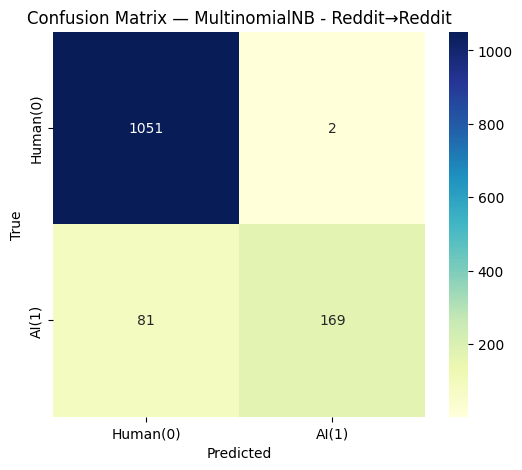

--- Debug Info for LinearSVC - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

LinearSVC - Reddit→Reddit
Accuracy : 0.9701
Micro-F1: 0.9701
Macro-F1: 0.9506

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.97      0.99      0.98      1053
       AI(1)       0.95      0.89      0.92       250

    accuracy                           0.97      1303
   macro avg       0.96      0.94      0.95      1303
weighted avg       0.97      0.97      0.97      1303



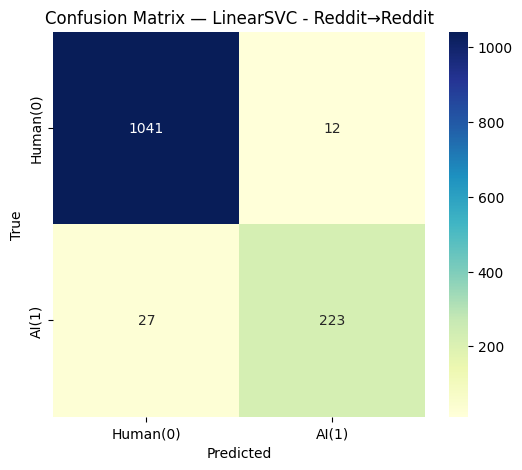

--- Debug Info for LogisticRegression - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

LogisticRegression - Reddit→Reddit
Accuracy : 0.9540
Micro-F1: 0.9540
Macro-F1: 0.9186

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.95      1.00      0.97      1053
       AI(1)       0.99      0.77      0.86       250

    accuracy                           0.95      1303
   macro avg       0.97      0.88      0.92      1303
weighted avg       0.96      0.95      0.95      1303



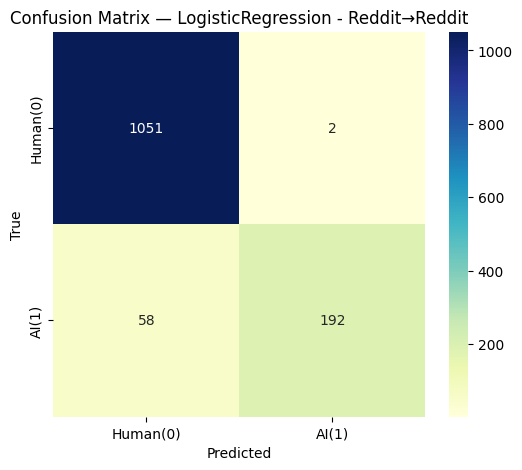

--- Debug Info for KNeighborsClassifier - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

KNeighborsClassifier - Reddit→Reddit
Accuracy : 0.8457
Micro-F1: 0.8457
Macro-F1: 0.6937

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.86      0.96      0.91      1053
       AI(1)       0.68      0.37      0.48       250

    accuracy                           0.85      1303
   macro avg       0.77      0.66      0.69      1303
weighted avg       0.83      0.85      0.83      1303



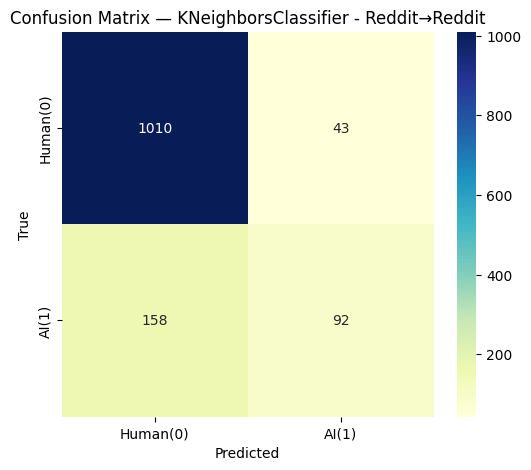

--- Debug Info for RandomForestClassifier - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

RandomForestClassifier - Reddit→Reddit
Accuracy : 0.9532
Micro-F1: 0.9532
Macro-F1: 0.9164

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.95      1.00      0.97      1053
       AI(1)       1.00      0.76      0.86       250

    accuracy                           0.95      1303
   macro avg       0.97      0.88      0.92      1303
weighted avg       0.96      0.95      0.95      1303



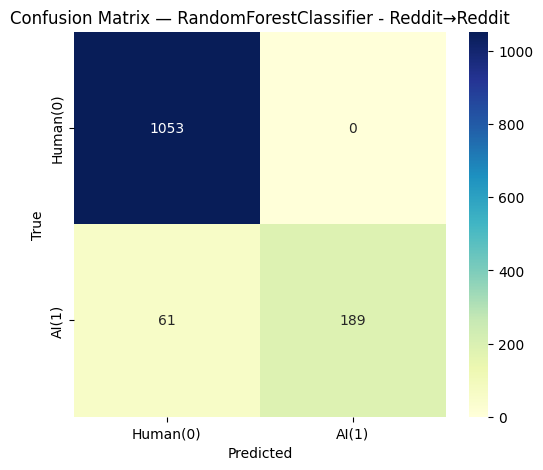

--- Debug Info for Simple CNN - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

Simple CNN - Reddit→Reddit
Accuracy : 0.9493
Micro-F1: 0.9493
Macro-F1: 0.9188

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.97      0.97      0.97      1053
       AI(1)       0.86      0.88      0.87       250

    accuracy                           0.95      1303
   macro avg       0.92      0.92      0.92      1303
weighted avg       0.95      0.95      0.95      1303



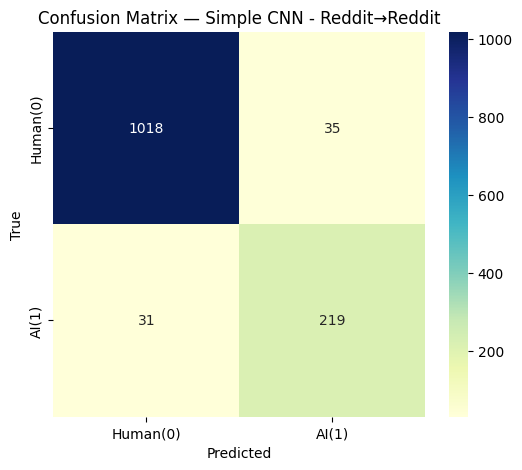

--- Debug Info for BiLSTM - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

BiLSTM - Reddit→Reddit
Accuracy : 0.8081
Micro-F1: 0.8081
Macro-F1: 0.4469

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.81      1.00      0.89      1053
       AI(1)       0.00      0.00      0.00       250

    accuracy                           0.81      1303
   macro avg       0.40      0.50      0.45      1303
weighted avg       0.65      0.81      0.72      1303



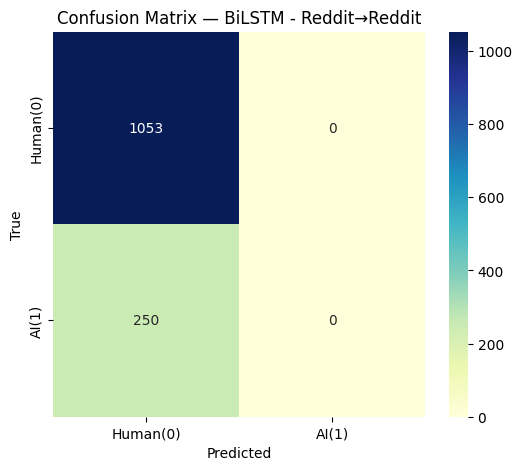

--- Debug Info for CNN+BiLSTM - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

CNN+BiLSTM - Reddit→Reddit
Accuracy : 0.7913
Micro-F1: 0.7913
Macro-F1: 0.5232

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.82      0.95      0.88      1053
       AI(1)       0.36      0.11      0.17       250

    accuracy                           0.79      1303
   macro avg       0.59      0.53      0.52      1303
weighted avg       0.73      0.79      0.74      1303



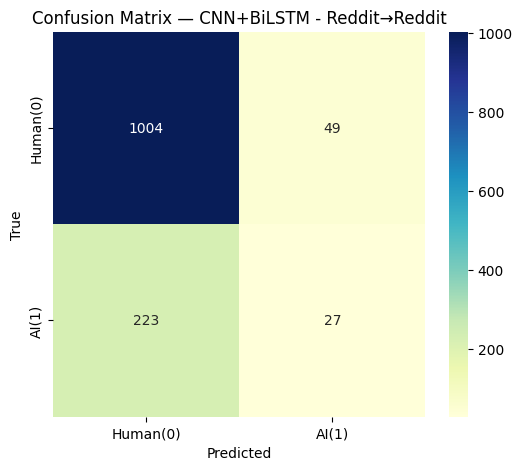


--- Debug: hf_trainer_models keys ---
dict_keys(['RoBERta Fine-tune'])
--- End Debug ---

--- Debug: Processing HF model: RoBERta Fine-tune ---
--- Debug: Calling RoBERta_Fine-tune training function ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saugata28-2 (saugata28-2-uow-university-of-wollongong-australia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.073400,0.047544
2,0.001900,0.028342
3,0.000200,0.028003


--- Debug Info for RoBERta Fine-tune - Reddit→Reddit ---
Shape of y_true: (1303,)
Shape of y_pred: (1303,)
--- End Debug Info ---

RoBERta Fine-tune - Reddit→Reddit
Accuracy : 0.9954
Micro-F1: 0.9954
Macro-F1: 0.9926

Classification Report:
              precision    recall  f1-score   support

    Human(0)       1.00      1.00      1.00      1053
       AI(1)       0.98      1.00      0.99       250

    accuracy                           1.00      1303
   macro avg       0.99      1.00      0.99      1303
weighted avg       1.00      1.00      1.00      1303



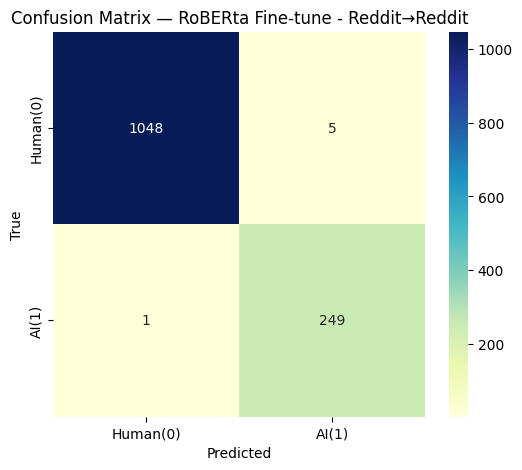


===== Evaluating One-Class Models (Reddit→Reddit) =====
--- Debug Info for OneClassSVM — Reddit→Reddit - OCC Evaluation ---
Shape of y_true: (2397,)
Shape of y_pred: (2397,)
--- End Debug Info ---

OneClassSVM — Reddit→Reddit - OCC Evaluation
Accuracy : 0.4176
Micro-F1: 0.4176
Macro-F1: 0.3652

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.41      0.82      0.55      1029
       AI(1)       0.46      0.11      0.18      1368

    accuracy                           0.42      2397
   macro avg       0.43      0.47      0.37      2397
weighted avg       0.44      0.42      0.34      2397



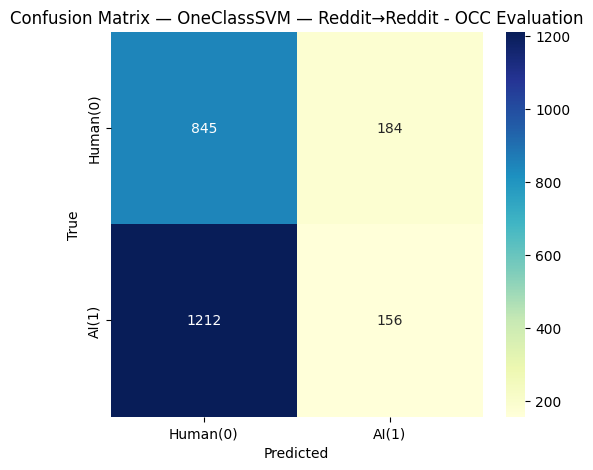

--- Debug Info for IsolationForest — Reddit→Reddit - OCC Evaluation ---
Shape of y_true: (2397,)
Shape of y_pred: (2397,)
--- End Debug Info ---

IsolationForest — Reddit→Reddit - OCC Evaluation
Accuracy : 0.3905
Micro-F1: 0.3905
Macro-F1: 0.2808

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.41      0.91      0.56      1029
       AI(1)       0.00      0.00      0.00      1368

    accuracy                           0.39      2397
   macro avg       0.20      0.45      0.28      2397
weighted avg       0.17      0.39      0.24      2397



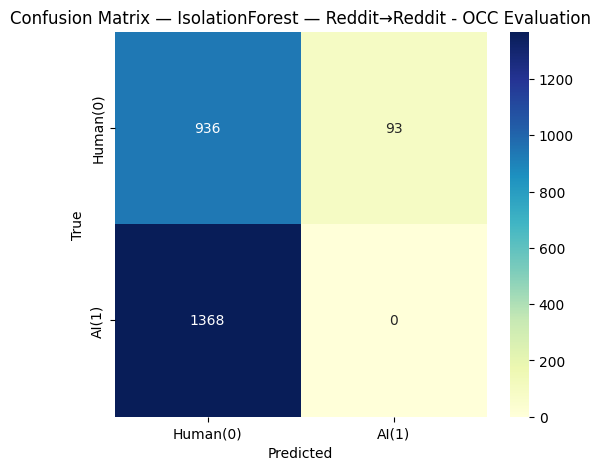

--- Debug Info for LocalOutlierFactor — Reddit→Reddit - OCC Evaluation ---
Shape of y_true: (2397,)
Shape of y_pred: (2397,)
--- End Debug Info ---

LocalOutlierFactor — Reddit→Reddit - OCC Evaluation
Accuracy : 0.4293
Micro-F1: 0.4293
Macro-F1: 0.3004

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.43      1.00      0.60      1029
       AI(1)       0.00      0.00      0.00      1368

    accuracy                           0.43      2397
   macro avg       0.21      0.50      0.30      2397
weighted avg       0.18      0.43      0.26      2397



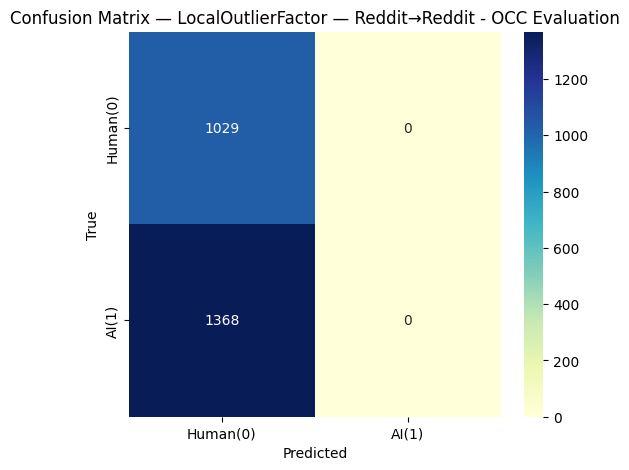


===== Evaluating Autoencoder (Reddit→Reddit) =====


--- Debug Info for Autoencoder — Reddit→Reddit - OCC Evaluation ---
Shape of y_true: (2397,)
Shape of y_pred: (2397,)
--- End Debug Info ---

Autoencoder — Reddit→Reddit - OCC Evaluation
Accuracy : 0.4289
Micro-F1: 0.4289
Macro-F1: 0.3020

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.43      1.00      0.60      1029
       AI(1)       0.43      0.00      0.00      1368

    accuracy                           0.43      2397
   macro avg       0.43      0.50      0.30      2397
weighted avg       0.43      0.43      0.26      2397



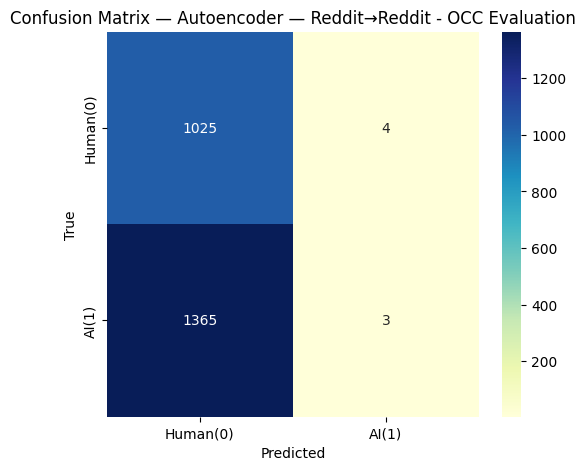


===== Evaluating Zero-Shot Baseline (GPT2 Perplexity) (Reddit→Reddit) =====


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


--- Debug Info for GPT2 Perplexity - Reddit→Reddit ---
Shape of y_true: (2397,)
Shape of y_pred: (2397,)
--- End Debug Info ---

GPT2 Perplexity - Reddit→Reddit
Accuracy : 0.4101
Micro-F1: 0.4101
Macro-F1: 0.2908

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.42      0.96      0.58      1029
       AI(1)       0.00      0.00      0.00      1368

    accuracy                           0.41      2397
   macro avg       0.21      0.48      0.29      2397
weighted avg       0.18      0.41      0.25      2397



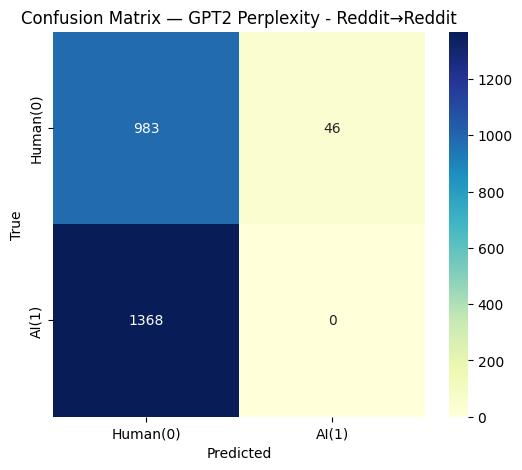

In [ ]:
# Same-domain
# Ensure datasets library is imported and Dataset class is available
from datasets import Dataset

print(f"Using Dataset type: {type(Dataset)}")

all_results.extend(run_experiment_regime(reddit_df, reddit_df, "Reddit→Reddit", same_domain=True))


===== Evaluating Baseline Models (Tweet→Tweet) =====
--- Debug Info for MultinomialNB - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

MultinomialNB - Tweet→Tweet
Accuracy : 0.6706
Micro-F1: 0.6706
Macro-F1: 0.6651

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.63      0.80      0.71      2542
       AI(1)       0.73      0.54      0.62      2573

    accuracy                           0.67      5115
   macro avg       0.68      0.67      0.67      5115
weighted avg       0.68      0.67      0.66      5115



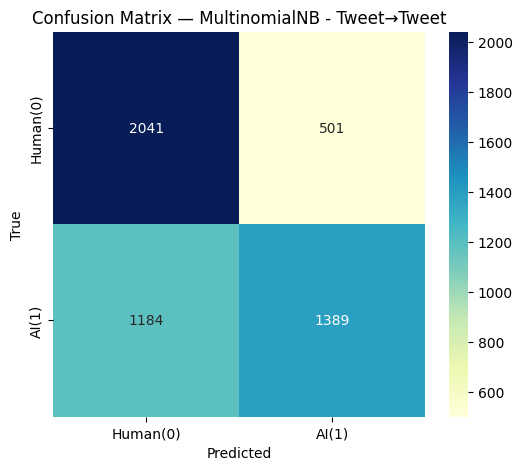

--- Debug Info for LinearSVC - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

LinearSVC - Tweet→Tweet
Accuracy : 0.6970
Micro-F1: 0.6970
Macro-F1: 0.6965

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.68      0.74      0.71      2542
       AI(1)       0.72      0.66      0.69      2573

    accuracy                           0.70      5115
   macro avg       0.70      0.70      0.70      5115
weighted avg       0.70      0.70      0.70      5115



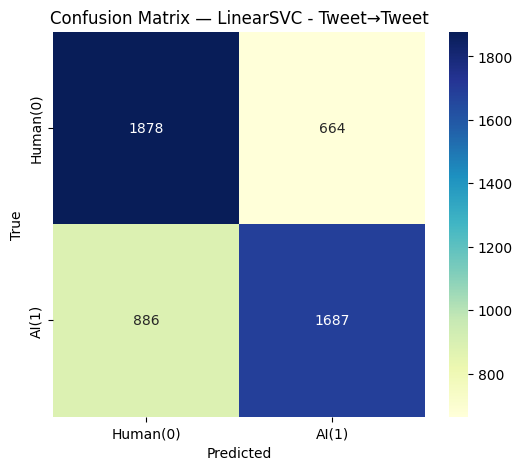

--- Debug Info for LogisticRegression - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

LogisticRegression - Tweet→Tweet
Accuracy : 0.7034
Micro-F1: 0.7034
Macro-F1: 0.7022

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.68      0.77      0.72      2542
       AI(1)       0.74      0.64      0.68      2573

    accuracy                           0.70      5115
   macro avg       0.71      0.70      0.70      5115
weighted avg       0.71      0.70      0.70      5115



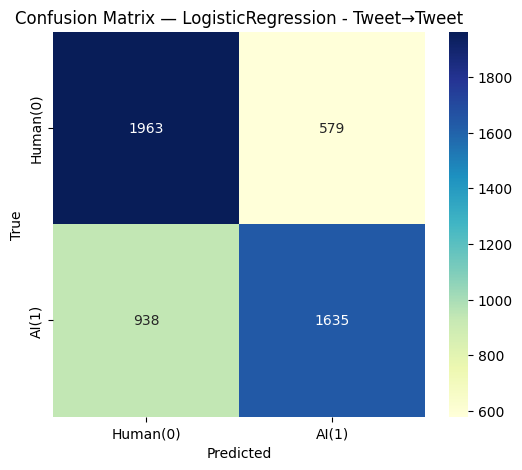

--- Debug Info for KNeighborsClassifier - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

KNeighborsClassifier - Tweet→Tweet
Accuracy : 0.5382
Micro-F1: 0.5382
Macro-F1: 0.4430

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.52      0.96      0.67      2542
       AI(1)       0.75      0.12      0.21      2573

    accuracy                           0.54      5115
   macro avg       0.63      0.54      0.44      5115
weighted avg       0.63      0.54      0.44      5115



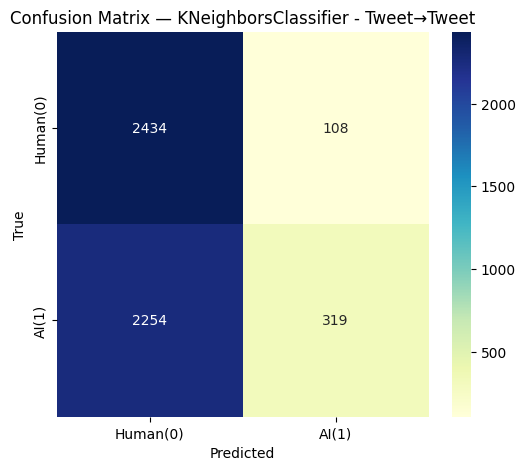

--- Debug Info for RandomForestClassifier - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

RandomForestClassifier - Tweet→Tweet
Accuracy : 0.6890
Micro-F1: 0.6890
Macro-F1: 0.6886

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.67      0.73      0.70      2542
       AI(1)       0.71      0.65      0.68      2573

    accuracy                           0.69      5115
   macro avg       0.69      0.69      0.69      5115
weighted avg       0.69      0.69      0.69      5115



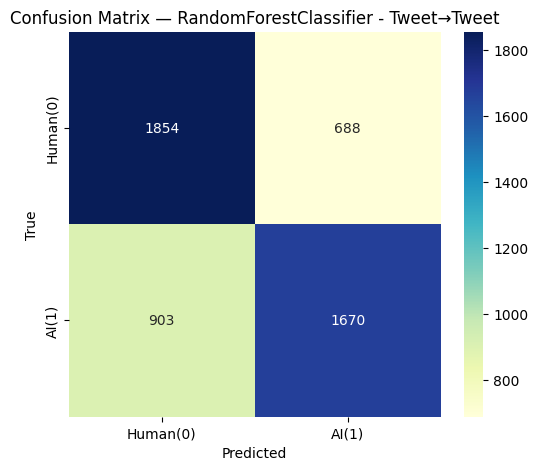

--- Debug Info for Simple CNN - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

Simple CNN - Tweet→Tweet
Accuracy : 0.6852
Micro-F1: 0.6852
Macro-F1: 0.6852

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.68      0.69      0.69      2542
       AI(1)       0.69      0.68      0.68      2573

    accuracy                           0.69      5115
   macro avg       0.69      0.69      0.69      5115
weighted avg       0.69      0.69      0.69      5115



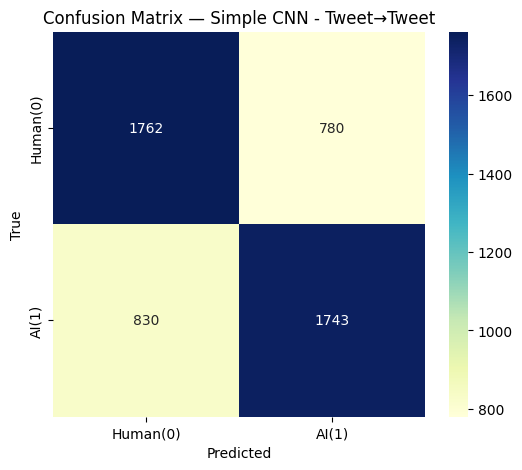

--- Debug Info for BiLSTM - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

BiLSTM - Tweet→Tweet
Accuracy : 0.4970
Micro-F1: 0.4970
Macro-F1: 0.3320

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      1.00      0.66      2542
       AI(1)       0.00      0.00      0.00      2573

    accuracy                           0.50      5115
   macro avg       0.25      0.50      0.33      5115
weighted avg       0.25      0.50      0.33      5115



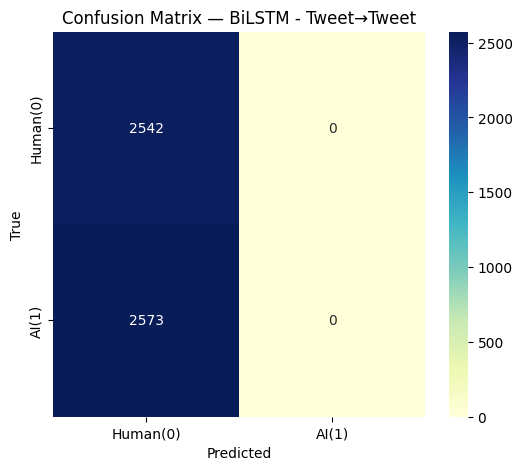

--- Debug Info for CNN+BiLSTM - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

CNN+BiLSTM - Tweet→Tweet
Accuracy : 0.5148
Micro-F1: 0.5148
Macro-F1: 0.4964

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.52      0.33      0.40      2542
       AI(1)       0.51      0.70      0.59      2573

    accuracy                           0.51      5115
   macro avg       0.52      0.51      0.50      5115
weighted avg       0.52      0.51      0.50      5115



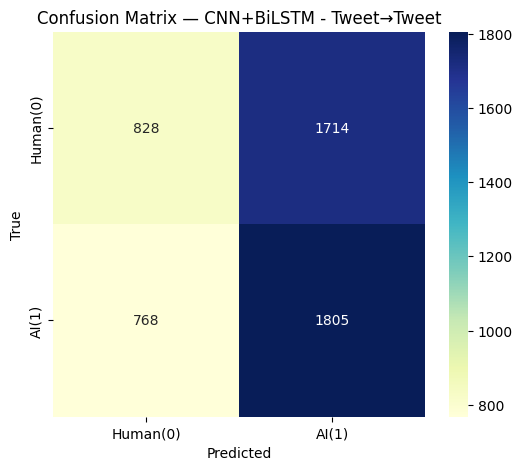


--- Debug: hf_trainer_models keys ---
dict_keys(['RoBERta Fine-tune'])
--- End Debug ---

--- Debug: Processing HF model: RoBERta Fine-tune ---
--- Debug: Calling RoBERta_Fine-tune training function ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.469500,0.373537
2,0.364100,0.363723
3,0.181700,0.566240


--- Debug Info for RoBERta Fine-tune - Tweet→Tweet ---
Shape of y_true: (5115,)
Shape of y_pred: (5115,)
--- End Debug Info ---

RoBERta Fine-tune - Tweet→Tweet
Accuracy : 0.8362
Micro-F1: 0.8362
Macro-F1: 0.8358

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.86      0.80      0.83      2542
       AI(1)       0.81      0.88      0.84      2573

    accuracy                           0.84      5115
   macro avg       0.84      0.84      0.84      5115
weighted avg       0.84      0.84      0.84      5115



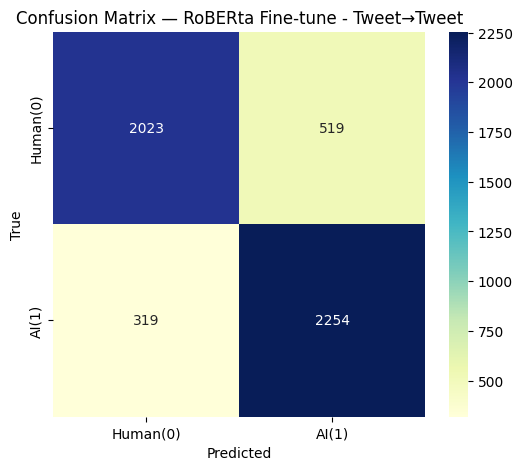


===== Evaluating One-Class Models (Tweet→Tweet) =====
--- Debug Info for OneClassSVM — Tweet→Tweet - OCC Evaluation ---
Shape of y_true: (15344,)
Shape of y_pred: (15344,)
--- End Debug Info ---

OneClassSVM — Tweet→Tweet - OCC Evaluation
Accuracy : 0.3083
Micro-F1: 0.3083
Macro-F1: 0.3067

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.17      0.78      0.27      2558
       AI(1)       0.83      0.21      0.34     12786

    accuracy                           0.31     15344
   macro avg       0.50      0.50      0.31     15344
weighted avg       0.72      0.31      0.33     15344



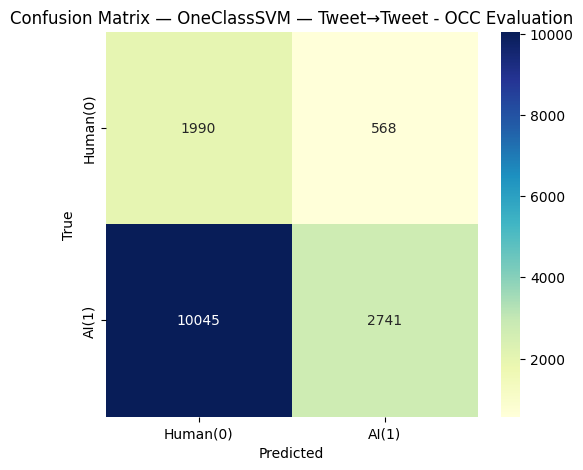

--- Debug Info for IsolationForest — Tweet→Tweet - OCC Evaluation ---
Shape of y_true: (15344,)
Shape of y_pred: (15344,)
--- End Debug Info ---

IsolationForest — Tweet→Tweet - OCC Evaluation
Accuracy : 0.1892
Micro-F1: 0.1892
Macro-F1: 0.1786

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.16      0.91      0.27      2558
       AI(1)       0.71      0.05      0.09     12786

    accuracy                           0.19     15344
   macro avg       0.44      0.48      0.18     15344
weighted avg       0.62      0.19      0.12     15344



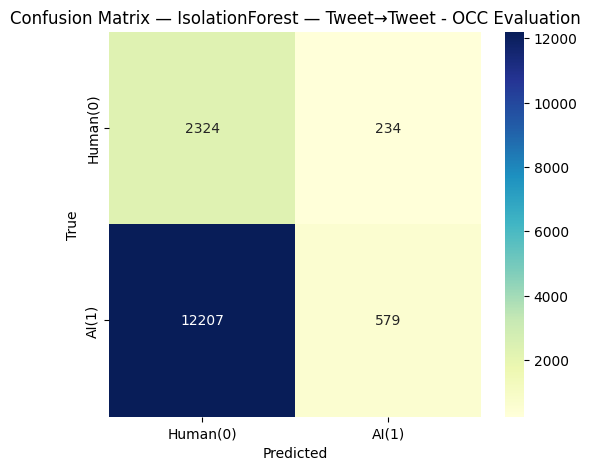

--- Debug Info for LocalOutlierFactor — Tweet→Tweet - OCC Evaluation ---
Shape of y_true: (15344,)
Shape of y_pred: (15344,)
--- End Debug Info ---

LocalOutlierFactor — Tweet→Tweet - OCC Evaluation
Accuracy : 0.8344
Micro-F1: 0.8344
Macro-F1: 0.4856

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.56      0.03      0.06      2558
       AI(1)       0.84      0.99      0.91     12786

    accuracy                           0.83     15344
   macro avg       0.70      0.51      0.49     15344
weighted avg       0.79      0.83      0.77     15344



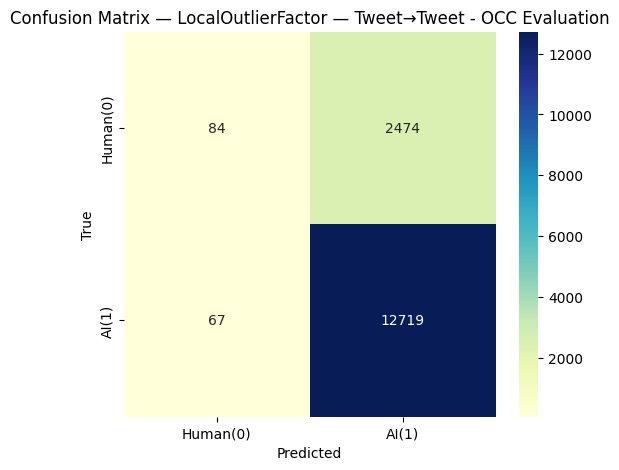


===== Evaluating Autoencoder (Tweet→Tweet) =====


--- Debug Info for Autoencoder — Tweet→Tweet - OCC Evaluation ---
Shape of y_true: (15344,)
Shape of y_pred: (15344,)
--- End Debug Info ---

Autoencoder — Tweet→Tweet - OCC Evaluation
Accuracy : 0.1759
Micro-F1: 0.1759
Macro-F1: 0.1581

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.16      0.96      0.28      2558
       AI(1)       0.72      0.02      0.04     12786

    accuracy                           0.18     15344
   macro avg       0.44      0.49      0.16     15344
weighted avg       0.62      0.18      0.08     15344



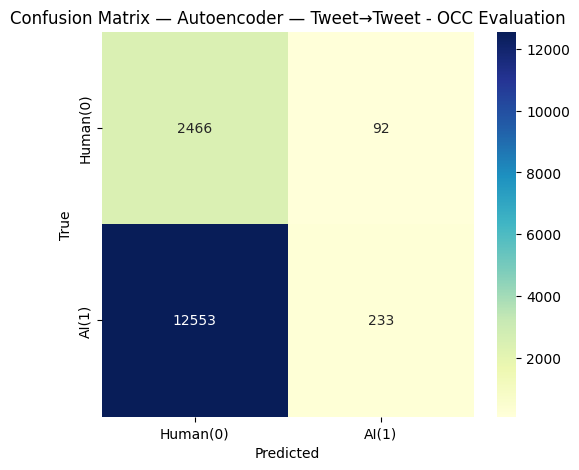


===== Evaluating Zero-Shot Baseline (GPT2 Perplexity) (Tweet→Tweet) =====
--- Debug Info for GPT2 Perplexity - Tweet→Tweet ---
Shape of y_true: (15344,)
Shape of y_pred: (15344,)
--- End Debug Info ---

GPT2 Perplexity - Tweet→Tweet
Accuracy : 0.1862
Micro-F1: 0.1862
Macro-F1: 0.1730

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.16      0.94      0.28      2558
       AI(1)       0.74      0.04      0.07     12786

    accuracy                           0.19     15344
   macro avg       0.45      0.49      0.17     15344
weighted avg       0.65      0.19      0.10     15344



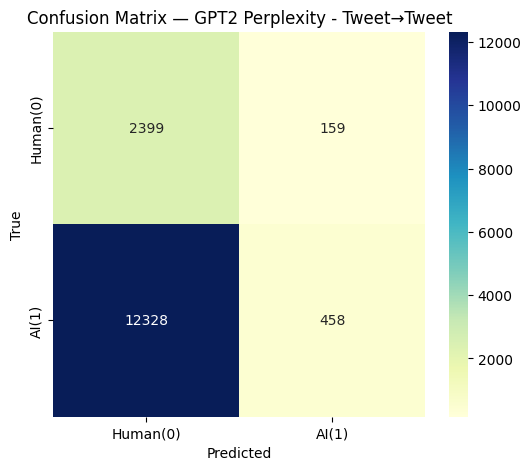

In [ ]:
all_results.extend(run_experiment_regime(tweet_df, tweet_df, "Tweet→Tweet", same_domain=True))



===== Evaluating Baseline Models (MixedAI→MixedAI) =====
--- Debug Info for MultinomialNB - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

MultinomialNB - MixedAI→MixedAI
Accuracy : 0.7789
Micro-F1: 0.7789
Macro-F1: 0.7787

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.80      0.75      0.77     21299
       AI(1)       0.76      0.81      0.79     21314

    accuracy                           0.78     42613
   macro avg       0.78      0.78      0.78     42613
weighted avg       0.78      0.78      0.78     42613



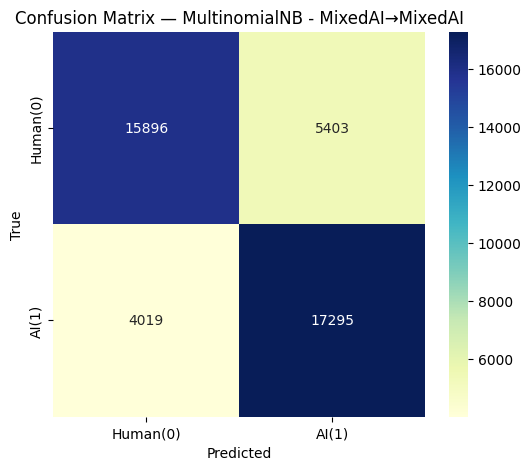

--- Debug Info for LinearSVC - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

LinearSVC - MixedAI→MixedAI
Accuracy : 0.9084
Micro-F1: 0.9084
Macro-F1: 0.9084

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.90      0.91      0.91     21299
       AI(1)       0.91      0.90      0.91     21314

    accuracy                           0.91     42613
   macro avg       0.91      0.91      0.91     42613
weighted avg       0.91      0.91      0.91     42613



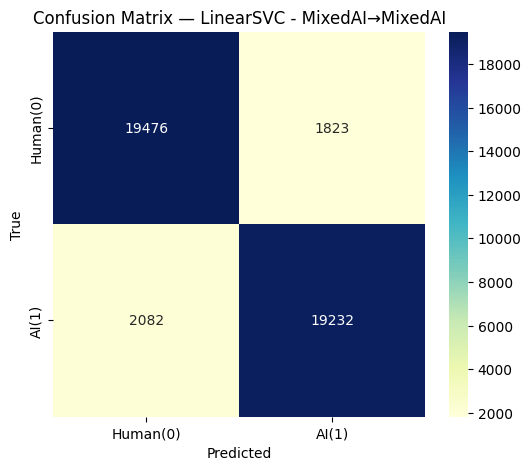

--- Debug Info for LogisticRegression - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

LogisticRegression - MixedAI→MixedAI
Accuracy : 0.9059
Micro-F1: 0.9059
Macro-F1: 0.9058

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.90      0.91      0.91     21299
       AI(1)       0.91      0.90      0.91     21314

    accuracy                           0.91     42613
   macro avg       0.91      0.91      0.91     42613
weighted avg       0.91      0.91      0.91     42613



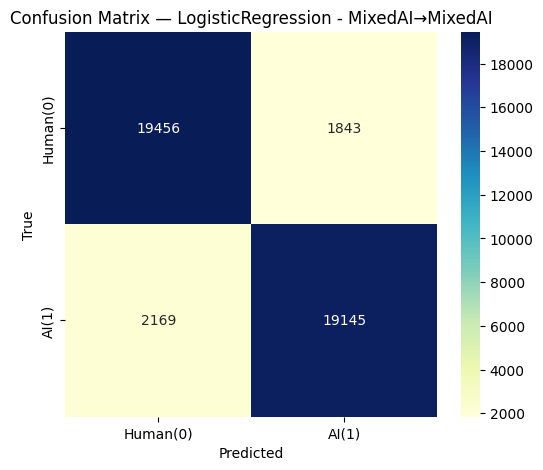

--- Debug Info for KNeighborsClassifier - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

KNeighborsClassifier - MixedAI→MixedAI
Accuracy : 0.6405
Micro-F1: 0.6405
Macro-F1: 0.5921

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.95      0.30      0.45     21299
       AI(1)       0.58      0.98      0.73     21314

    accuracy                           0.64     42613
   macro avg       0.77      0.64      0.59     42613
weighted avg       0.77      0.64      0.59     42613



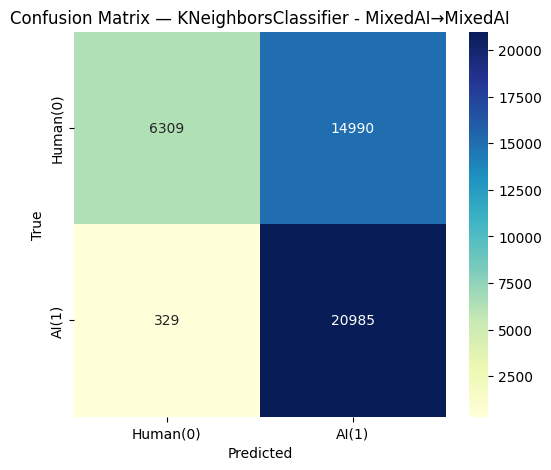

--- Debug Info for RandomForestClassifier - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

RandomForestClassifier - MixedAI→MixedAI
Accuracy : 0.8668
Micro-F1: 0.8668
Macro-F1: 0.8668

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.86      0.87      0.87     21299
       AI(1)       0.87      0.86      0.87     21314

    accuracy                           0.87     42613
   macro avg       0.87      0.87      0.87     42613
weighted avg       0.87      0.87      0.87     42613



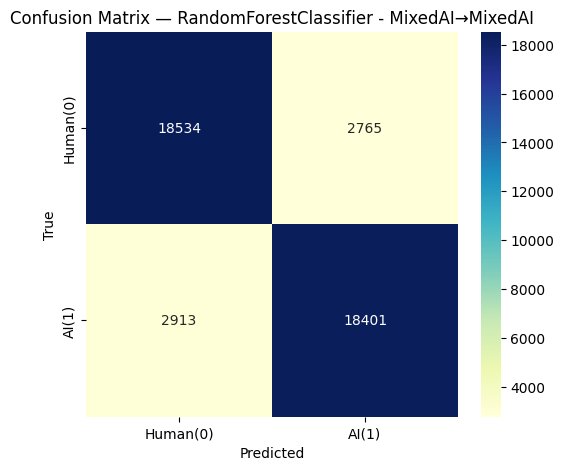

--- Debug Info for Simple CNN - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

Simple CNN - MixedAI→MixedAI
Accuracy : 0.9345
Micro-F1: 0.9345
Macro-F1: 0.9345

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.93      0.93      0.93     21299
       AI(1)       0.93      0.93      0.93     21314

    accuracy                           0.93     42613
   macro avg       0.93      0.93      0.93     42613
weighted avg       0.93      0.93      0.93     42613



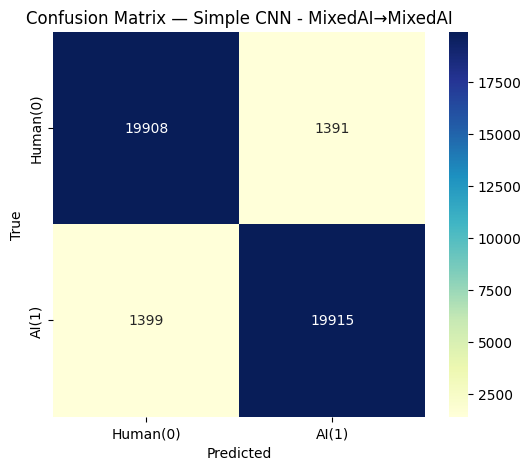


Skipping remaining TF-IDF deep learning models for regime MixedAI→MixedAI due to error: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[153404,5000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StridedSlice] name: strided_slice/

--- Debug: hf_trainer_models keys ---
dict_keys(['RoBERta Fine-tune'])
--- End Debug ---

--- Debug: Processing HF model: RoBERta Fine-tune ---
--- Debug: Calling RoBERta_Fine-tune training function ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.688700,0.693482
2,0.687000,0.716196
3,0.688200,0.958624


--- Debug Info for RoBERta Fine-tune - MixedAI→MixedAI ---
Shape of y_true: (42613,)
Shape of y_pred: (42613,)
--- End Debug Info ---

RoBERta Fine-tune - MixedAI→MixedAI
Accuracy : 0.5002
Micro-F1: 0.5002
Macro-F1: 0.3335

Classification Report:
              precision    recall  f1-score   support

    Human(0)       1.00      0.00      0.00     21299
       AI(1)       0.50      1.00      0.67     21314

    accuracy                           0.50     42613
   macro avg       0.75      0.50      0.33     42613
weighted avg       0.75      0.50      0.33     42613



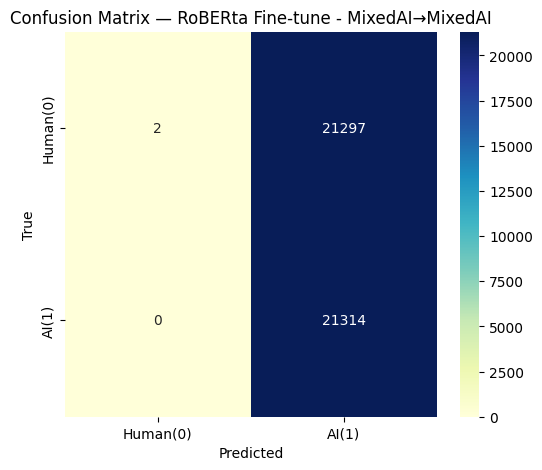


===== Evaluating One-Class Models (MixedAI→MixedAI) =====
--- Debug Info for OneClassSVM — MixedAI→MixedAI - OCC Evaluation ---
Shape of y_true: (127838,)
Shape of y_pred: (127838,)
--- End Debug Info ---

OneClassSVM — MixedAI→MixedAI - OCC Evaluation
Accuracy : 0.1859
Micro-F1: 0.1859
Macro-F1: 0.1720

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.16      0.95      0.28     21307
       AI(1)       0.76      0.03      0.06    106531

    accuracy                           0.19    127838
   macro avg       0.46      0.49      0.17    127838
weighted avg       0.66      0.19      0.10    127838



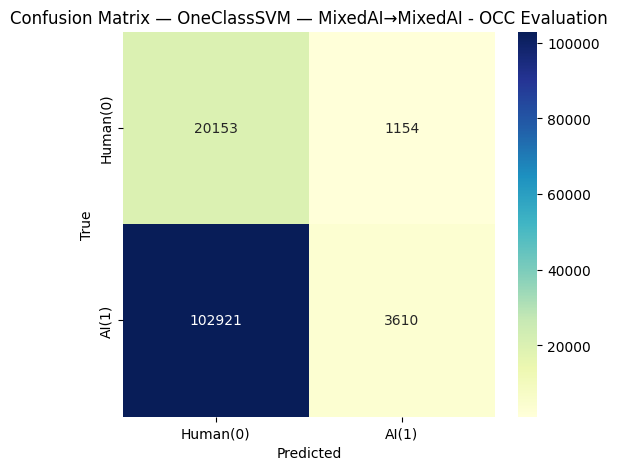

--- Debug Info for IsolationForest — MixedAI→MixedAI - OCC Evaluation ---
Shape of y_true: (127838,)
Shape of y_pred: (127838,)
--- End Debug Info ---

IsolationForest — MixedAI→MixedAI - OCC Evaluation
Accuracy : 0.3640
Micro-F1: 0.3640
Macro-F1: 0.3614

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.20      0.90      0.32     21307
       AI(1)       0.93      0.26      0.40    106531

    accuracy                           0.36    127838
   macro avg       0.56      0.58      0.36    127838
weighted avg       0.81      0.36      0.39    127838



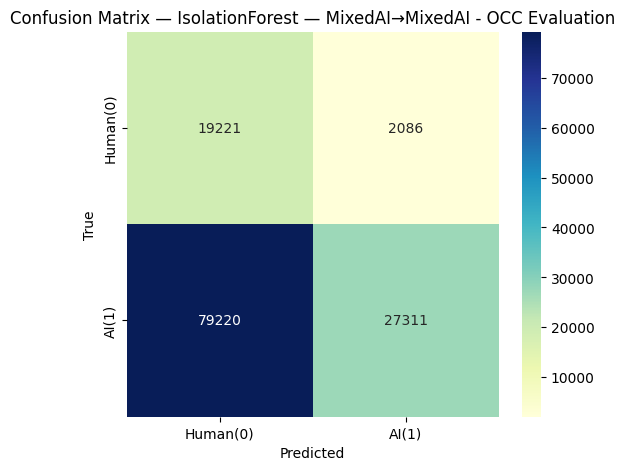

--- Debug Info for LocalOutlierFactor — MixedAI→MixedAI - OCC Evaluation ---
Shape of y_true: (127838,)
Shape of y_pred: (127838,)
--- End Debug Info ---

LocalOutlierFactor — MixedAI→MixedAI - OCC Evaluation
Accuracy : 0.1667
Micro-F1: 0.1667
Macro-F1: 0.1429

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.17      1.00      0.29     21307
       AI(1)       1.00      0.00      0.00    106531

    accuracy                           0.17    127838
   macro avg       0.58      0.50      0.14    127838
weighted avg       0.86      0.17      0.05    127838



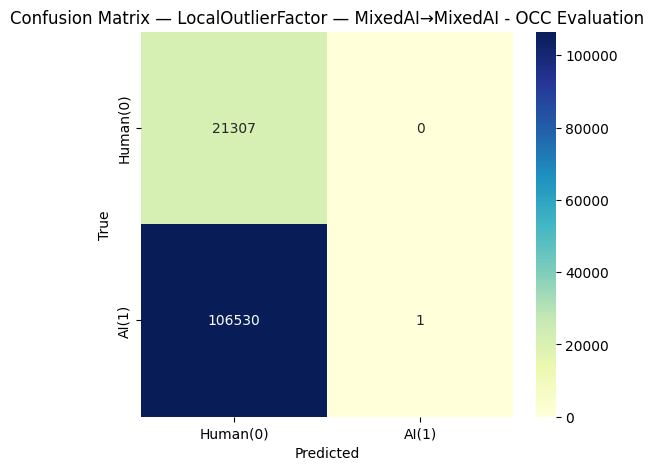


===== Evaluating Autoencoder (MixedAI→MixedAI) =====


--- Debug Info for Autoencoder — MixedAI→MixedAI - OCC Evaluation ---
Shape of y_true: (127838,)
Shape of y_pred: (127838,)
--- End Debug Info ---

Autoencoder — MixedAI→MixedAI - OCC Evaluation
Accuracy : 0.1779
Micro-F1: 0.1779
Macro-F1: 0.1612

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.16      0.96      0.28     21307
       AI(1)       0.72      0.02      0.04    106531

    accuracy                           0.18    127838
   macro avg       0.44      0.49      0.16    127838
weighted avg       0.63      0.18      0.08    127838



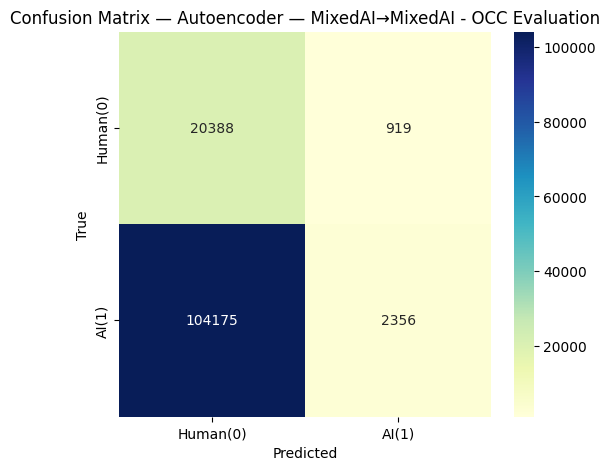


===== Evaluating Zero-Shot Baseline (GPT2 Perplexity) (MixedAI→MixedAI) =====


In [ ]:
all_results.extend(run_experiment_regime(mixed_ai_df, mixed_ai_df, "MixedAI→MixedAI", same_domain=True)) # Added MixedAI same-domain
#all_results.extend(run_experiment_regime(combined_df, combined_df, "Combined→Combined", same_domain=True))




===== Evaluating Baseline Models (Reddit→Tweet) =====
--- Debug Info for MultinomialNB - Reddit→Tweet ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

MultinomialNB - Reddit→Tweet
Accuracy : 0.4986
Micro-F1: 0.4986
Macro-F1: 0.3342

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      1.00      0.66     12786
       AI(1)       0.27      0.00      0.00     12786

    accuracy                           0.50     25572
   macro avg       0.39      0.50      0.33     25572
weighted avg       0.39      0.50      0.33     25572



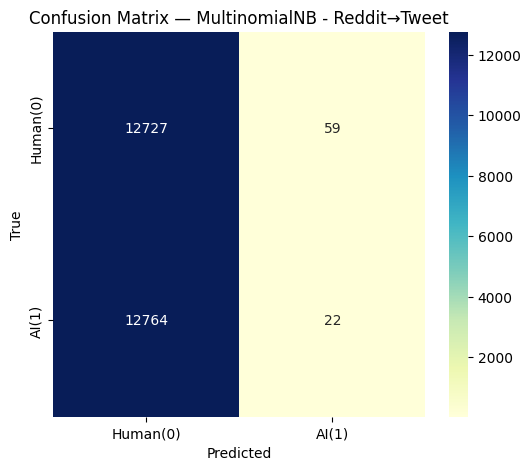

--- Debug Info for LinearSVC - Reddit→Tweet ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

LinearSVC - Reddit→Tweet
Accuracy : 0.5013
Micro-F1: 0.5013
Macro-F1: 0.3549

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      0.98      0.66     12786
       AI(1)       0.53      0.02      0.05     12786

    accuracy                           0.50     25572
   macro avg       0.51      0.50      0.35     25572
weighted avg       0.51      0.50      0.35     25572



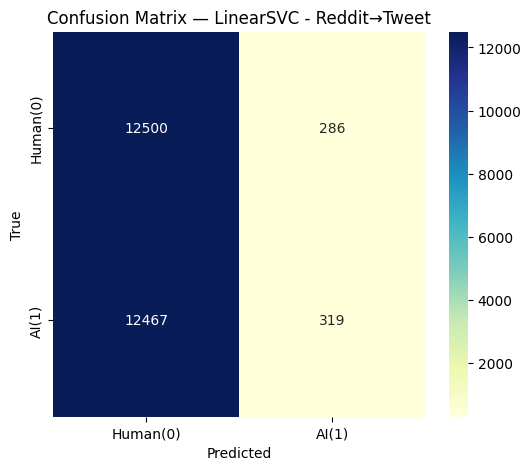

--- Debug Info for LogisticRegression - Reddit→Tweet ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

LogisticRegression - Reddit→Tweet
Accuracy : 0.4996
Micro-F1: 0.4996
Macro-F1: 0.3396

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      0.99      0.66     12786
       AI(1)       0.47      0.01      0.01     12786

    accuracy                           0.50     25572
   macro avg       0.49      0.50      0.34     25572
weighted avg       0.49      0.50      0.34     25572



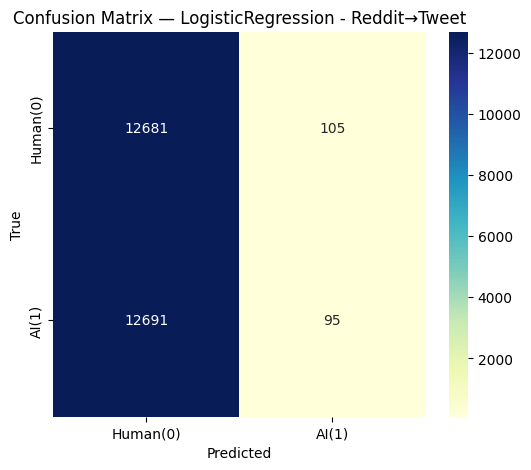

--- Debug Info for KNeighborsClassifier - Reddit→Tweet ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

KNeighborsClassifier - Reddit→Tweet
Accuracy : 0.4991
Micro-F1: 0.4991
Macro-F1: 0.3566

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      0.97      0.66     12786
       AI(1)       0.48      0.03      0.05     12786

    accuracy                           0.50     25572
   macro avg       0.49      0.50      0.36     25572
weighted avg       0.49      0.50      0.36     25572



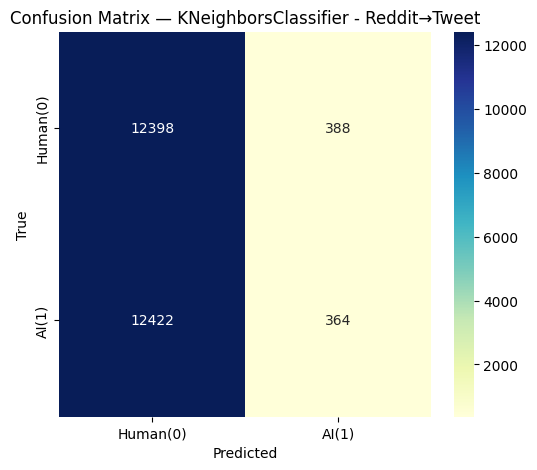

--- Debug Info for RandomForestClassifier - Reddit→Tweet ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

RandomForestClassifier - Reddit→Tweet
Accuracy : 0.4998
Micro-F1: 0.4998
Macro-F1: 0.3333

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      1.00      0.67     12786
       AI(1)       0.17      0.00      0.00     12786

    accuracy                           0.50     25572
   macro avg       0.33      0.50      0.33     25572
weighted avg       0.33      0.50      0.33     25572



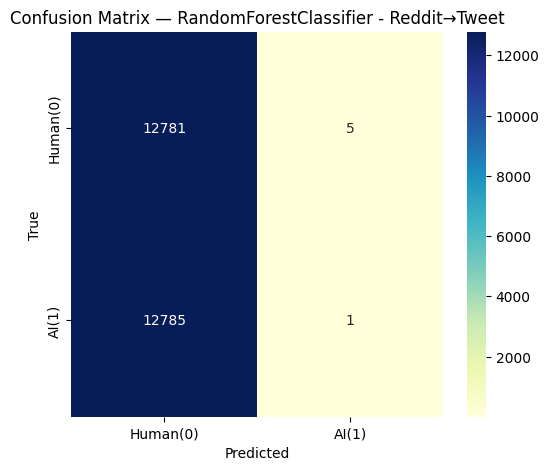


Skipping remaining TF-IDF deep learning models for regime Reddit→Tweet due to error: Graph execution error:

Detected at node gradient_tape/sequential_27/max_pooling1d_18/MaxPool/MaxPoolGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-pac

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.066000,4.386713
2,0.051700,4.653594
3,0.000100,5.218858


--- Debug Info for RoBERta Fine-tune - Reddit→Tweet ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

RoBERta Fine-tune - Reddit→Tweet
Accuracy : 0.4828
Micro-F1: 0.4828
Macro-F1: 0.3285

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.49      0.96      0.65     12786
       AI(1)       0.08      0.00      0.01     12786

    accuracy                           0.48     25572
   macro avg       0.29      0.48      0.33     25572
weighted avg       0.29      0.48      0.33     25572



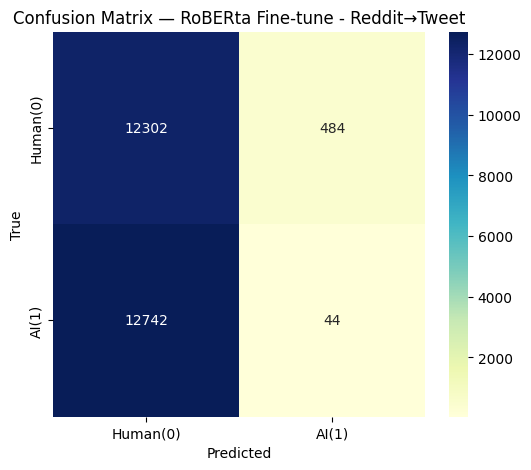


===== Evaluating One-Class Models (Reddit→Tweet) =====
--- Debug Info for OneClassSVM — Reddit→Tweet - OCC Evaluation ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

OneClassSVM — Reddit→Tweet - OCC Evaluation
Accuracy : 0.4621
Micro-F1: 0.4621
Macro-F1: 0.4409

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.44      0.27      0.33     12786
       AI(1)       0.47      0.66      0.55     12786

    accuracy                           0.46     25572
   macro avg       0.46      0.46      0.44     25572
weighted avg       0.46      0.46      0.44     25572



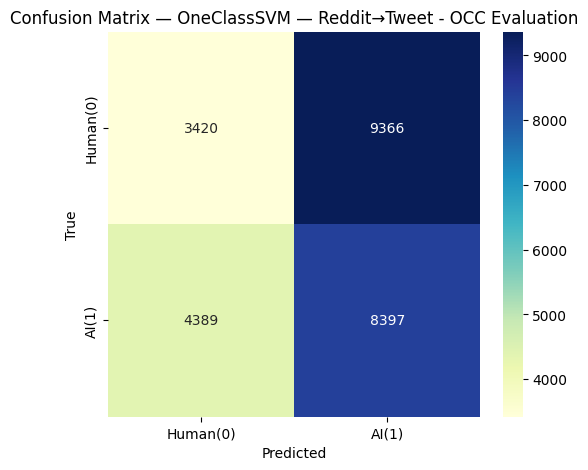

--- Debug Info for IsolationForest — Reddit→Tweet - OCC Evaluation ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

IsolationForest — Reddit→Tweet - OCC Evaluation
Accuracy : 0.5000
Micro-F1: 0.5000
Macro-F1: 0.3333

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      1.00      0.67     12786
       AI(1)       0.00      0.00      0.00     12786

    accuracy                           0.50     25572
   macro avg       0.25      0.50      0.33     25572
weighted avg       0.25      0.50      0.33     25572



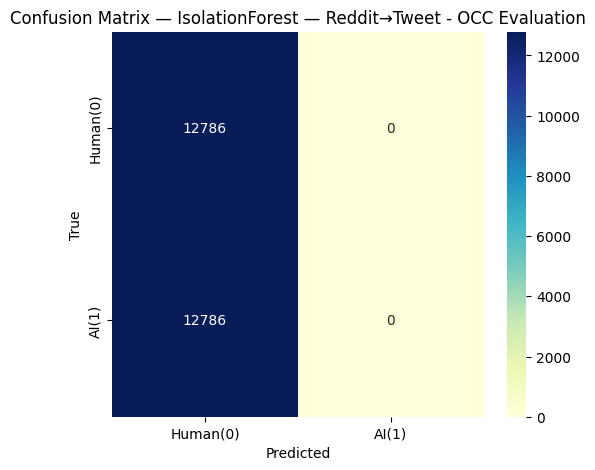

--- Debug Info for LocalOutlierFactor — Reddit→Tweet - OCC Evaluation ---
Shape of y_true: (25572,)
Shape of y_pred: (25572,)
--- End Debug Info ---

LocalOutlierFactor — Reddit→Tweet - OCC Evaluation
Accuracy : 0.5000
Micro-F1: 0.5000
Macro-F1: 0.3333

Classification Report:
              precision    recall  f1-score   support

    Human(0)       0.50      1.00      0.67     12786
       AI(1)       0.00      0.00      0.00     12786

    accuracy                           0.50     25572
   macro avg       0.25      0.50      0.33     25572
weighted avg       0.25      0.50      0.33     25572



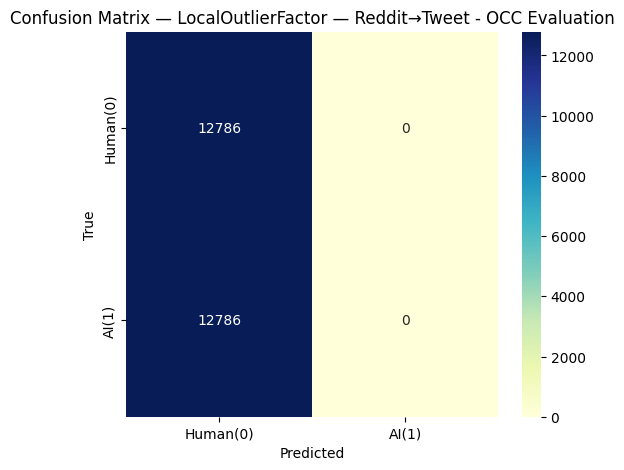

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Cross-domain
all_results.extend(run_experiment_regime(reddit_df, tweet_df, "Reddit→Tweet", same_domain=False))


In [ ]:
all_results.extend(run_experiment_regime(tweet_df, reddit_df, "Tweet→Reddit", same_domain=False))


In [ ]:
all_results.extend(run_experiment_regime(reddit_df, mixed_ai_df, "Reddit→MixedAI", same_domain=False)) # Added Reddit to MixedAI


In [ ]:
all_results.extend(run_experiment_regime(tweet_df, mixed_ai_df, "Tweet→MixedAI", same_domain=False)) # Added Tweet to MixedAI


In [ ]:
all_results.extend(run_experiment_regime(mixed_ai_df, reddit_df, "MixedAI→Reddit", same_domain=False)) # Added MixedAI to Reddit


In [ ]:
all_results.extend(run_experiment_regime(mixed_ai_df, tweet_df, "MixedAI→Tweet", same_domain=False)) # Added MixedAI to Tweet


In [ ]:
all_results.extend(run_experiment_regime(combined_df, reddit_df, "Combined→Reddit", same_domain=False))


In [ ]:
all_results.extend(run_experiment_regime(combined_df, tweet_df, "Combined→Tweet", same_domain=False))


In [ ]:
all_results.extend(run_experiment_regime(combined_df, mixed_ai_df, "Combined→MixedAI", same_domain=False)) # Added Combined to MixedAI




In [ ]:
# Convert results to DataFrame for easier analysis
all_results_df = pd.DataFrame(all_results)

In [ ]:
print(all_results_df)

Empty DataFrame
Columns: [Accuracy, Micro-F1, Macro-F1]
Index: []


In [ ]:
all_results_df = pd.DataFrame(all_results)

print("\n\n===== EXPERIMENT SUMMARY =====")
display(all_results_df.sort_values(by=["Regime", "Macro-F1"], ascending=[True, False]))

# Plot
plot_df = all_results_df.dropna(subset=['Macro-F1'])
plt.figure(figsize=(15, 7))
sns.barplot(data=plot_df, x="Regime", y="Macro-F1", hue="Model")
plt.title("Model Performance (Macro-F1) Across Regimes")
plt.ylabel("Macro-F1 Score")
plt.xlabel("Experiment Regime")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
